this copy was made to update all the analysis stuff with the new and improved metric 1/gaussianified metric

### Load molsim and packages

In [1]:
import csv
import matplotlib
from tqdm import tqdm
import scipy.stats
from scipy.stats import norm
from string import punctuation 

In [2]:
#calling molsim


%run -i /Users/molsim/ipython_quickstart.py 

In [21]:
#%matplotlib widget

### Load the TMC-1 Data and such that only need to be done once

In [3]:
#drv on dropbox
tmc1 = load_obs('/DR5_v2.npz')



ll0,ul0 = find_limits(tmc1.spectrum.frequency)

### Load the CSV File

In [14]:

with open('summary_2024_final.csv', mode ='r') as input:   #your csv to be analyzed
      
    csvdata = list(csv.DictReader(input)) 
    
 

### Utility functions for later

In [7]:
def find_rms(freq,x,y,fwhm=0.3,nfwhm=10):
    
    minf = freq - fwhm*nfwhm*freq/ckm
    maxf = freq + fwhm*nfwhm*freq/ckm
    
    minc = find_nearest(x,minf)
    maxc = find_nearest(x,maxf)
    
    return get_rms(y[minc:maxc])

### Define an object to hold the results

In [8]:
class Result(object):
    '''
    The Result object holds all the results and metadata for a single molecule
    You always have to assign this!!!!!!!! i.e. something =Results()... 
    if you just write Results(...) it immediately disappears, and is not stored. 
    '''
    
    def __init__(
                    self, #self is a placehodler for anything in front of the .id, .name, etc
                    id = None, #(Int) Hannah's molecule ID, i.e. 0, 1, 2, etc.
                    name = None, #(Str) Molecule name
                    formula = None, #(Str) Molecule formula
                    log_pred_cd = None, #(Float) The predicted column density, in log10 space
                    log_pred_err = None, #(Float) The predicted column density error, in log10 space
                    log_pred_cd_low = None, #(Float) The lower limit of the predicted column density, in log10 space
                    log_pred_cd_high = None, #(Float) The upper limit of the predicted column density, in log10 space
                    pred_cd = None, #(Float) The predicted column density in linear space
                    pred_cd_low = None, #(Float) The lower limit of the predicted column density, in linear space
                    pred_cd_high = None, #(Float) The upper limit of the predicted column density, in linear space
                    five_sig_thresh = None, #(Float) The column density at which there are three lines >= 5 sigma NOT IN LOG
                    three_sig_thresh = None, #(Float) The column density at which there are three lines >= 3 sigma
                    percent_metric = None, #(Float) Hannah's metric for how much of the predicted space is detectable
                    percent_metric_st = None, #(Float) Hannah's metric for how much of the predicted space is detectable
                    cat = None, #(Str) catalog file name
                    qpart = None, #(Str) qpart file name
                    path = None, #(Str) file path
                    flags = None, #(list) a list to add flags to in case of errors, for tracking
                    five_sig_thresh_st = None, # #same as above but metric 2 The column density at which there are three lines >= 5 sigma NOT IN LOG
                    numLinesOver = None, #how many lines are over the threshold intensity. for metric 2
                    pred_cd_st = None #HISTORIC, DO NOT USE linear space CD for the stacked lines in metric 2

                    
            ):
        
        self.id = id #self. means locally stored variable unique to this instance of this class
        self.name = name
        self.formula = formula
        self.log_pred_cd = log_pred_cd
        self.log_pred_err = log_pred_err
        self.log_pred_cd_low = log_pred_cd_low
        self.log_pred_cd_high = log_pred_cd_high
        self.pred_cd = pred_cd
        self.pred_cd_low = pred_cd_low
        self.pred_cd_high = pred_cd_high  
        self.five_sig_thresh = five_sig_thresh
        self.three_sig_thresh = three_sig_thresh
        self.percent_metric = percent_metric
        self.percent_metric_st = percent_metric_st
        self.cat = cat
        self.qpart = qpart
        self.path = path
        self.flags = flags
        self.five_sig_thresh_st = five_sig_thresh_st
        self.numLinesOver = numLinesOver
        self.pred_cd_st = pred_cd_st
        
        #this is calling the function to run calc_cds on this object's variables... in this case my molecule
        self._calc_cds() #() mean it calls the calc_cd command on itself
        #done mostly out of convenience bc we know we will do this each time on all my objects
        
        self._set_files()
        
        return
    
    
    #This function runs automatically when the object is created to fill in the other column density values
    def _calc_cds(self): #the _ indicates it should not be used outside class and it's bc it's in initialization and i wont have to use it outside the class
        
        self.log_pred_cd_low = self.log_pred_cd - self.log_pred_err #calculate the lower bound in log space
        self.log_pred_cd_high = self.log_pred_cd + self.log_pred_err #calculate the upper bound in log space
        
        self.pred_cd = 10**self.log_pred_cd #get the CD in linear space
        self.pred_cd_low = 10**self.log_pred_cd_low #get the lower bound in linear space
        self.pred_cd_high = 10**self.log_pred_cd_high #get the upper bound in linear space
        
        return 
    
    #This function runs automatically when the object is created to fill in the filenames using Hannah's conventions
    def _set_files(self):
        
        if self.cat is None: #check to make sure the user didn't specify it directly
            self.cat = f'{self.path}/{self.id}partFn.cat'
            
        if self.qpart is None: #check to make sure the user didn't specify it directly
            self.qpart = f'{self.path}/{self.id}.qpart'
        
        return
    
    
    
    
    #This will make a plot of the molecule simulation in SNR space at the 5 sigma threshold column density
    #This is a little needlessly slow because it re-loads the GOTHAM data each time, but you shouldn't be using this function terribly often anyway
    def plot_five_sig(self): #so this is not used in initialization and can be used outside initialization as many times as i want
        
        #check if there were lines in the range
        if self.flags is not None and 'No Lines in Range' in self.flags:
            print('No lines were in the range to simulate, so cannot plot anything.  Sorry.')
            return
        
        #check to make sure the five sigma analysis was run
        if self.five_sig_thresh is None:
            print('No threshold has been set yet.  Cannot plot.  Sorry.')
            return
       

    
  
        #data reduction 
        tmc1 = load_obs('/DR5_v2.npz')
        
        
        
        
        ll0,ul0 = find_limits(tmc1.spectrum.frequency)
    
        mol = load_mol(self.cat, type='SPCAT', qpart_file=self.qpart)
        src = Source(dV = 0.3, velocity=5.8,Tex=7,column=self.five_sig_thresh)
        sim = Simulation(mol=mol,ll=ll0,ul=ul0,observation=tmc1,source=src,line_profile='Gaussian',res=0.0014)
        
        rms_vals = []
        for x in sim.spectrum.frequency:
            rms_vals.append(find_rms(x,tmc1.spectrum.frequency,tmc1.spectrum.Tb))
        rms_vals = np.asarray(rms_vals)
    
        #find the SNR values
        snr_vals = sim.spectrum.Tb / rms_vals        
        
        plt.close("SNR Vals")
        fig = plt.figure(num="SNR Vals", figsize=(10, 8))
        plt.ion()

        ax = fig.add_subplot(111)

        plt.xlabel("Frequency (MHz)")
        plt.ylabel("SNR")

        ax.tick_params(axis="x", which="both", direction="in", length=15, width=1)
        ax.tick_params(axis="y", which="both", direction="in", length=15, width=1)
        ax.yaxis.set_ticks_position("both")
        ax.xaxis.set_ticks_position("both")

        ax.stem(sim.spectrum.frequency,snr_vals,linefmt='black',markerfmt=" ",basefmt=" ")
        
        ax.annotate(f'{self.name}',xy=[0.95,0.95],xycoords='axes fraction',ha='right',va='top',color='black')
        ax.annotate(f'{self.formula}',xy=[0.95,0.90],xycoords='axes fraction',ha='right',va='top',color='black')
        ax.annotate(f'{self.five_sig_thresh:.2e} cm-2',xy=[0.95,0.85],xycoords='axes fraction',ha='right',va='top',color='black')
       


        
        plt.show()       
        
        return
    
    
    
    #This will make a plot of the molecule simulation in SNR space at an arbitrary column density
    #This is a little needlessly slow because it re-loads the GOTHAM data each time, but you shouldn't be using this function terribly often anyway
    def plot(self,col):
        
        #check if there were lines in the range
        if self.flags is not None and 'No Lines in Range' in self.flags:
            print('No lines were in the range to simulate, so cannot plot anything.  Sorry.')
            return
       
     
        
        


        #data reduction on laptop
        tmc1 = load_obs('/DR5_v2.npz')
        
        
        
        
        
        ll0,ul0 = find_limits(tmc1.spectrum.frequency)
    
        mol = load_mol(self.cat, type='SPCAT', qpart_file=self.qpart)
        src = Source(dV = 0.3, velocity=5.8,Tex=7,column=col)
        sim = Simulation(mol=mol,ll=ll0,ul=ul0,observation=tmc1,source=src,line_profile='Gaussian',res=0.0014)
        
        rms_vals = []
        for x in sim.spectrum.frequency:
            rms_vals.append(find_rms(x,tmc1.spectrum.frequency,tmc1.spectrum.Tb))
        rms_vals = np.asarray(rms_vals)
    
        #find the SNR values
        snr_vals = sim.spectrum.Tb / rms_vals        
        
        plt.close("SNR Vals")
        fig = plt.figure(num="SNR Vals", figsize=(10, 8))
        plt.ion()

        ax = fig.add_subplot(111)

        plt.xlabel("Frequency (MHz)")
        plt.ylabel("SNR")

        ax.tick_params(axis="x", which="both", direction="in", length=15, width=1)
        ax.tick_params(axis="y", which="both", direction="in", length=15, width=1)
        ax.yaxis.set_ticks_position("both")
        ax.xaxis.set_ticks_position("both")

        ax.stem(sim.spectrum.frequency,snr_vals,linefmt='black',markerfmt=" ",basefmt=" ")
        
        ax.annotate(f'{self.name}',xy=[0.95,0.95],xycoords='axes fraction',ha='right',va='top',color='black')
        ax.annotate(f'{self.formula}',xy=[0.95,0.90],xycoords='axes fraction',ha='right',va='top',color='black')
        ax.annotate(f'{col:.2e} cm-2',xy=[0.95,0.85],xycoords='axes fraction',ha='right',va='top',color='black')

        plt.show()       
        
        return

    
    
    
    

    #############additional working functions for visualization###################
    def gaussianVisual(self): #(freq, mu, minCD):
        """

        """   
        #check if there were lines in the range
        if self.flags is not None and 'No Lines in Range' in self.flags:
            #print('No lines were in the range to simulate, so cannot plot anything.  Sorry.')
            return

        #check to make sure the five sigma analysis was run
        if self.five_sig_thresh is None:
    #            print('No threshold has been set yet.  Cannot plot.  Sorry.')
            return


        #variables for plot
        mu = self.log_pred_cd
        stanDev = self.log_pred_err
        x_axis = np.linspace(self.log_pred_cd_low - 8,self.log_pred_cd_high + 8,1000 )
        minCD = np.log10(self.five_sig_thresh)
        areaUnderCurve = round(self.errorGauss5sigma(),3)
        yvalueMu = np.interp(mu, x_axis,norm.pdf(x_axis, mu,stanDev))
        minCDymax = np.interp(minCD, x_axis,norm.pdf(x_axis, mu,stanDev))
        
        #actual plot data
        plt.figure(figsize=(15, 8))
        plt.plot(x_axis, norm.pdf(x_axis, mu,stanDev), color = 'deepskyblue', linewidth = 2.5)
        plt.axvline(x = mu, color = 'black', label = 'ML-predicted CD', linewidth = 2, ymax=.95)
        plt.axhline(y=0, color = 'deepskyblue', linewidth = 2)
        plt.axvline(x=minCD, color = 'hotpink', label='min CD', ymax=((minCDymax)/(yvalueMu))*.93)
        mu_val = plt.plot(mu,0, marker = 'o', color = 'black') #ML-predicted CD val
        minCD_val = plt.plot(minCD,0, marker='o', color = 'hotpink')



        #filling the curved area
        x_vis = x_axis[(x_axis>=minCD) ]
        plt.fill_between(x_vis, norm.pdf(x_vis, mu, stanDev), alpha = 0.5, color = 'hotpink', label=(str(areaUnderCurve)+'% "detectability"'))


        #making plots pretty
        plt.xlabel("Log Column Densities")
        plt.legend(loc = 'upper right', fontsize=8)

        #tick management
        plt.yticks([])
        plt.xticks([mu, minCD], rotation = 320)
        plt.tick_params(axis='y', which='both', right=False, left=False, labelleft=False)
        ax = plt.gca()#get current axes
        ax.set_frame_on(False);
    
    def errorGauss5sigma_st(self):
        #check if there were lines in the range
        if self.flags is not None and 'No Lines in Range' in self.flags:
            #print('No lines were in the range to simulate, so cannot plot anything.  Sorry.')
            return

        #check to make sure the five sigma analysis was run
        if self.five_sig_thresh_st is None:
            #print(' ')
            #print('No threshold has been set yet.  Cannot plot.  Sorry.')
            return


        cdf_st = scipy.stats.norm.cdf(np.log10(self.five_sig_thresh_st), self.log_pred_cd, self.log_pred_err)
        gaussRtTail_st = 1-cdf_st
        percVis_st = gaussRtTail_st*100
        return percVis_st
    
    
    def errorGauss5sigma(self):
        """
        metric 1: within each gaussian,  
        """
        
        #check if there were lines in the range
        if self.flags is not None and 'No Lines in Range' in self.flags:
            #print('No lines were in the range to simulate, so cannot plot anything.  Sorry.')
            return

        #check to make sure the five sigma analysis was run
        if self.five_sig_thresh is None:
            #print(' ')
            #print('No threshold has been set yet.  Cannot plot.  Sorry.')
            return


        cdf = scipy.stats.norm.cdf(np.log10(self.five_sig_thresh), self.log_pred_cd, self.log_pred_err)
        gaussRtTail = 1-cdf
        percVis = gaussRtTail*100
        return percVis

    

    
    def five_sigma_line_val(self): #so this is not used in initialization and can be used outside initialization as many times as i want
        
        """
        metric 1
        gives the red line for where there is 3 lines over 5 sigma threshold CD
               
        
        """
 
        #check if there were lines in the range
        if self.flags is not None and 'No Lines in Range' in self.flags:
            print('No lines were in the range to simulate, so cannot plot anything.  Sorry.')
            return
        
        #check to make sure the five sigma analysis was run
        if self.five_sig_thresh is None:
            print('No threshold has been set yet.  Cannot plot.  Sorry.')
            return
       

    

        #data reduction 
        tmc1 = load_obs('/DR5_v2.npz')
        
        
        
        ll0,ul0 = find_limits(tmc1.spectrum.frequency)
    
        mol = load_mol(self.cat, type='SPCAT', qpart_file=self.qpart)
        src = Source(dV = 0.3, velocity=5.8,Tex=7,column=self.five_sig_thresh)
        sim = Simulation(mol=mol,ll=ll0,ul=ul0,observation=tmc1,source=src,line_profile='Gaussian',res=0.0014)
        
        rms_vals = []
        for x in sim.spectrum.frequency:
            rms_vals.append(find_rms(x,tmc1.spectrum.frequency,tmc1.spectrum.Tb))
        rms_vals = np.asarray(rms_vals)
        
        
        #find the SNR values
        snr_vals = sim.spectrum.Tb / rms_vals         
        sort_idx = np.argsort(snr_vals)[::-1]
    
        sort_Tbx = np.argsort(sim.spectrum.Tb)[::-1]
        
        return snr_vals[sort_idx[2]]
        
    def plot_fivesig_withThresh(self): #so this is not used in initialization and can be used outside initialization as many times as i want
        
        
        """
        metric 1
        plot the spectra with SNR adjustments up to the 3 lines over 5 sigma limit
        and a red line to show where the exact
        3 linves over 5 sigma limit is
        
        """
        #check if there were lines in the range
        if self.flags is not None and 'No Lines in Range' in self.flags:
            print('No lines were in the range to simulate, so cannot plot anything.  Sorry.')
            return
        
        #check to make sure the five sigma analysis was run
        if self.five_sig_thresh is None:
            print('No threshold has been set yet.  Cannot plot.  Sorry.')
            return
       


        #data reduction 
        tmc1 = load_obs('/DR5_v2.npz')
        
        
        
        ll0,ul0 = find_limits(tmc1.spectrum.frequency)
    
        mol = load_mol(self.cat, type='SPCAT', qpart_file=self.qpart)
        src = Source(dV = 0.3, velocity=5.8,Tex=7,column=self.five_sig_thresh)
        sim = Simulation(mol=mol,ll=ll0,ul=ul0,observation=tmc1,source=src,line_profile='Gaussian',res=0.0014)
        
        rms_vals = []
        for x in sim.spectrum.frequency:
            rms_vals.append(find_rms(x,tmc1.spectrum.frequency,tmc1.spectrum.Tb))
        rms_vals = np.asarray(rms_vals)
    
        #find the SNR values
        snr_vals = sim.spectrum.Tb / rms_vals        
        
        plt.close("SNR Vals")
        fig = plt.figure(num="SNR Vals", figsize=(12, 10))
        plt.ion()

        ax = fig.add_subplot(111)

        plt.xlabel("Frequency (MHz)", fontsize=20)
        plt.ylabel("SNR", fontsize=20)
        #log_col = np.log10(col)

        ax.tick_params(axis="x", which="both", direction="in", length=15, width=1, labelsize=15)
        ax.tick_params(axis="y", which="both", direction="in", length=15, width=1, labelsize=15)
        ax.yaxis.set_ticks_position("both")
        ax.xaxis.set_ticks_position("both")

        ax.stem(sim.spectrum.frequency,snr_vals,linefmt='black',markerfmt=" ",basefmt=" ")
        
        #ax.annotate(f'{self.name}',xy=[0.95,0.95],xycoords='axes fraction',ha='right',va='top',color='black')
        ax.annotate(f'{self.formula}',xy=[0.95,0.90],xycoords='axes fraction',ha='right',va='top',color='black')
        ax.annotate(f'{self.five_sig_thresh:.2e} cm-2',xy=[0.95,0.85],xycoords='axes fraction',ha='right',va='top',color='black')
       
    #test line below
        plt.axhline(y=molecules2[i].five_sigma_line_val(), color ='r')

        
        plt.show()       
        
        return        
    def plot_with_line(self,col):
        """
        plots figures with SNR
        at chosen column densities
        with metric 1 red line threshold
        
        """
        
        #check if there were lines in the range
        if self.flags is not None and 'No Lines in Range' in self.flags:
            print('No lines were in the range to simulate, so cannot plot anything.  Sorry.')
            return
       
     
        
        
        
  
        #data reduction 
        tmc1 = load_obs('/DR5_v2.npz')
        
        
        
        
        
        ll0,ul0 = find_limits(tmc1.spectrum.frequency)
    
        mol = load_mol(self.cat, type='SPCAT', qpart_file=self.qpart)
        src = Source(dV = 0.3, velocity=5.8,Tex=7,column=col)
        sim = Simulation(mol=mol,ll=ll0,ul=ul0,observation=tmc1,source=src,line_profile='Gaussian',res=0.0014)
        
        rms_vals = []
        for x in sim.spectrum.frequency:
            rms_vals.append(find_rms(x,tmc1.spectrum.frequency,tmc1.spectrum.Tb))
        rms_vals = np.asarray(rms_vals)
    
        #find the SNR values
        snr_vals = sim.spectrum.Tb / rms_vals        
        
        plt.close("SNR Vals")
        fig = plt.figure(num="SNR Vals", figsize=(10, 8))
        plt.ion()

        ax = fig.add_subplot(111)

        plt.xlabel("Frequency (MHz)")
        plt.ylabel("SNR")
        
        log_col = np.log10(col)

        ax.tick_params(axis="x", which="both", direction="in", length=15, width=1)
        ax.tick_params(axis="y", which="both", direction="in", length=15, width=1)
        ax.yaxis.set_ticks_position("both")
        ax.xaxis.set_ticks_position("both")

        ax.stem(sim.spectrum.frequency,snr_vals,linefmt='black',markerfmt=" ",basefmt=" ")
        
        ax.annotate(f'{self.name}',xy=[0.95,0.95],xycoords='axes fraction',ha='right',va='top',color='black')
        ax.annotate(f'{self.formula}',xy=[0.95,0.90],xycoords='axes fraction',ha='right',va='top',color='black')
        ax.annotate(f'{log_col:.2f} cm-2',xy=[0.95,0.85],xycoords='axes fraction',ha='right',va='top',color='black')
        plt.axhline(y=molecules2[i].five_sigma_line_val(), color ='r')

        plt.show()       
        
        return    
            
     ############function testing space###################
    
    
    #i think from here
    # i can write the plot function with defined column densitiesi
    #like you choose your own
#    but always plot the red line
    
    def plot_metric2_withLine(self,col):
        """
        plots figures with SNR
        at chosen column densities
        with metric 1 red line threshold
        
        """
        
        #check if there were lines in the range
        if self.flags is not None and 'No Lines in Range' in self.flags:
            print('No lines were in the range to simulate, so cannot plot anything.  Sorry.')
            return
       
     
        
        
        
     

        #data reduction
        tmc1 = load_obs('/DR5_v2.npz')
        
        
        
        
        
        
        ll0,ul0 = find_limits(tmc1.spectrum.frequency)
    
        mol = load_mol(self.cat, type='SPCAT', qpart_file=self.qpart)
        src = Source(dV = 0.3, velocity=5.8,Tex=7,column=col)
        sim = Simulation(mol=mol,ll=ll0,ul=ul0,observation=tmc1,source=src,line_profile='Gaussian',res=0.0014)
        
        rms_vals = []
        for x in sim.spectrum.frequency:
            rms_vals.append(find_rms(x,tmc1.spectrum.frequency,tmc1.spectrum.Tb))
        rms_vals = np.asarray(rms_vals)
    
        #find the SNR values
        snr_vals = sim.spectrum.Tb / rms_vals        
        
        
        #find the arguments to sort the snr_vals array. 
        sort_idx = np.argsort(snr_vals)[::-1] #argsort is small to large so -1 is large to small

        #do the same for Tbx
        sort_Tbx = np.argsort(sim.spectrum.Tb)[::-1]        
        """
         HOPE THIS WORKS
        """       
        """
        i think i have to specifically apply the new SNR to the specific peaks. 
        
        """
        ####metric 2######
        #find the most intense line
        intensePeakSNR = (snr_vals[sort_idx[0]]) #gives SNR of most intense peak
        intensePeakTb = (sim.spectrum.Tb[sort_Tbx[0]]) #gives Tb of most intense line

        # define my minimum thresholds
        percentageOfMax = 0.75
        stackMinTb = percentageOfMax * intensePeakTb

        # find all instances of anything over threshPeakVal in snr_vals
        #this is the issue--this gives an arary of arrays
        #instancesOver = np.argwhere( snr_vals >= threshPeakVal) #might not work
        instancesOver = ((sim.spectrum.Tb >= stackMinTb).sum())
        
        
        #next, we need to multiply sqrt(# lines) by the SNR of the most intense SNR peak
        #SNR of highest peak
        #this gives us a new "stacking" appropriate 
        guesstimateSNR = np.sqrt((instancesOver)) * intensePeakSNR        
        
        
        """
        something here. 
        """
        #new_lines =[]
        for i in range(len(snr_vals)):
            #something bout finding the value of the points it's true's snr_vals and replacing it with 
            #guesstimatesnr value
            if sim.spectrum.Tb[i]>=stackMinTb:
                snr_vals[i] = guesstimateSNR
            else:
                continue 

        


        
        



        
        
        
        
        
        plt.close("SNR Vals")
        fig = plt.figure(num="SNR Vals", figsize=(10, 8))
        plt.ion()

        ax = fig.add_subplot(111)

        plt.xlabel("Frequency (MHz)")
        plt.ylabel("SNR")
        
        log_col = np.log10(col)

        ax.tick_params(axis="x", which="both", direction="in", length=15, width=1)
        ax.tick_params(axis="y", which="both", direction="in", length=15, width=1)
        ax.yaxis.set_ticks_position("both")
        ax.xaxis.set_ticks_position("both")

        ax.stem(sim.spectrum.frequency,snr_vals,linefmt='black',markerfmt=" ",basefmt=" ")
        
        ax.annotate(f'{self.name}',xy=[0.95,0.95],xycoords='axes fraction',ha='right',va='top',color='black')
        ax.annotate(f'{self.formula}',xy=[0.95,0.90],xycoords='axes fraction',ha='right',va='top',color='black')
        ax.annotate(f'{log_col:.2f} cm-2',xy=[0.95,0.85],xycoords='axes fraction',ha='right',va='top',color='black')
        #plt.axhline(y=molecules2[i].five_sigma_line_val(), color ='r')

        plt.show()       
        
        return    

    
    
    #############these do not work yet#################       
    
    
    
    
    
    
    
    


    
    
    
    def plot_desired_thresh(self,col):
        """
        metric 2
        plots a red line where you have defined a so-called threshold peak intensity for line stacking
        i.e., the stack should have all lines over 75% of the max peak's intensity
        and the red line would be where the 75% is
        """
        
        #check if there were lines in the range
        if self.flags is not None and 'No Lines in Range' in self.flags:
            print('No lines were in the range to simulate, so cannot plot anything.  Sorry.')
            return
       
     

        #data reduction on laptop
        tmc1 = load_obs('/DR5_v2.npz')
        

        
        
        ll0,ul0 = find_limits(tmc1.spectrum.frequency)
    
        mol = load_mol(self.cat, type='SPCAT', qpart_file=self.qpart)
        src = Source(dV = 0.3, velocity=5.8,Tex=7,column=col)
        sim = Simulation(mol=mol,ll=ll0,ul=ul0,observation=tmc1,source=src,line_profile='Gaussian',res=0.0014)
        
        rms_vals = []
        for x in sim.spectrum.frequency:
            rms_vals.append(find_rms(x,tmc1.spectrum.frequency,tmc1.spectrum.Tb))
        rms_vals = np.asarray(rms_vals)
    
        #find the SNR values
        snr_vals = sim.spectrum.Tb / rms_vals 
        sort_idx = np.argsort(snr_vals)[::-1] #argsort is small to large so -1 is large to small

        #do the same for Tbx
        sort_Tbx = np.argsort(sim.spectrum.Tb)[::-1]




        ####metric 2######
        #find the most intense line
        intensePeakSNR = (snr_vals[sort_idx[0]]) #gives SNR of most intense peak
        intensePeakTb = (sim.spectrum.Tb[sort_Tbx[0]]) #gives Tb of most intense line

        # define my minimum thresholds
        percentageOfMax = 0.75
        stackMinTb = percentageOfMax * intensePeakTb #float

        # find all instances of anything over threshPeakVal in snr_vals
        instancesOver = np.argwhere( sim.spectrum.Tb > stackMinTb)
        
        plt.close("stacked SNR Vals")
        fig = plt.figure(num="stacked SNR Vals", figsize=(10, 8))
        plt.ion()

        ax = fig.add_subplot(111)

        plt.xlabel("Frequency (MHz)")
        plt.ylabel("Tb")

        ax.tick_params(axis="x", which="both", direction="in", length=15, width=1)
        ax.tick_params(axis="y", which="both", direction="in", length=15, width=1)
        ax.yaxis.set_ticks_position("both")
        ax.xaxis.set_ticks_position("both")

        #ax.stem(sim.spectrum.frequency,newIntse,linefmt='black',markerfmt=" ",basefmt=" ")
        ax.stem(sim.spectrum.frequency,sim.spectrum.Tb,linefmt='black',markerfmt=" ",basefmt=" ")
        
        ax.annotate(f'{self.name}',xy=[0.95,0.95],xycoords='axes fraction',ha='right',va='top',color='black')
        ax.annotate(f'{self.formula}',xy=[0.95,0.90],xycoords='axes fraction',ha='right',va='top',color='black')
        ax.annotate(f'{col:.2e} cm-2',xy=[0.95,0.85],xycoords='axes fraction',ha='right',va='top',color='black')
        ax.annotate(f'{len(instancesOver)}',xy=[0.95,0.80],xycoords='axes fraction',ha='right',va='top',color='black')
        plt.axhline(y=stackMinTb, color = 'r')
        plt.show()       

        return
    



            
#########testing##############
#########testing##############
#########testing###########
    def plot_5sigma_thresh_metric1(self,col):
        """
        metric 1
        plots the spectra at specified column densities with a red line at the 5 sigma value.
        """
        
         #check if there were lines in the range
        if self.flags is not None and 'No Lines in Range' in self.flags:
            print('No lines were in the range to simulate, so cannot plot anything.  Sorry.')
            return
        
        #data reduction on laptop
        tmc1 = load_obs('/DR5_v2.npz')
        
        ll0,ul0 = find_limits(tmc1.spectrum.frequency)
    
    ###PLOT's conditions####
        mol = load_mol(self.cat, type='SPCAT', qpart_file=self.qpart)
        src = Source(dV = 0.3, velocity=5.8,Tex=7,column=col)
        sim = Simulation(mol=mol,ll=ll0,ul=ul0,observation=tmc1,source=src,line_profile='Gaussian',res=0.0014)
        
        rms_vals = []
        for x in sim.spectrum.frequency:
            rms_vals.append(find_rms(x,tmc1.spectrum.frequency,tmc1.spectrum.Tb))
        rms_vals = np.asarray(rms_vals)
    
    
    ###for SNR_values of 5 sigma CD
        mol2 = load_mol(self.cat, type='SPCAT', qpart_file=self.qpart)
        src2 = Source(dV = 0.3, velocity=5.8,Tex=7,column=self.five_sig_thresh)
        sim2 = Simulation(mol=mol2,ll=ll0,ul=ul0,observation=tmc1,source=src2,line_profile='Gaussian',res=0.0014)
        
        rms_vals2 = []
        for x2 in sim2.spectrum.frequency:
            rms_vals2.append(find_rms(x2,tmc1.spectrum.frequency,tmc1.spectrum.Tb))
        rms_vals2 = np.asarray(rms_vals2)
    
        #find the SNR values
        snr_vals = sim2.spectrum.Tb / rms_vals2 
        sort_idx = np.argsort(snr_vals)[::-1] #argsort is small to large so -1 is large to small

        #do the same for Tbx
        sort_Tbx = np.argsort(sim2.spectrum.Tb)[::-1]

                      
        ####metric 1######
        thirdPeakSNR = (snr_vals[sort_idx[2]]) #gives SNR of 3rd most intense peak
        thirdPeakTb = (sim2.spectrum.Tb[sort_Tbx[2]]) #gives Tb of 3rdmost intense line

        # find all instances of anything over threshPeakVal in snr_vals
        instancesOver = np.argwhere( sim.spectrum.Tb > thirdPeakTb)        
        
        plt.close("???SNR Vals")
        fig = plt.figure(num="??SNR Vals", figsize=(10, 8))
        plt.ion()

        ax = fig.add_subplot(111)

        plt.xlabel("Frequency (MHz)", fontsize=20)
        plt.ylabel("Tb", fontsize=20)
        
        log_col = np.log10(col)

        ax.tick_params(axis="x", which="both", direction="in", length=15, width=1, labelsize=18)
        ax.tick_params(axis="y", which="both", direction="in", length=15, width=1,labelsize=18)
        ax.yaxis.set_ticks_position("both")
        ax.xaxis.set_ticks_position("both")
#simulate the spectra of the plot at the desired CD, with red line indicating where the 5 sigma would be

        ax.stem(sim.spectrum.frequency,sim.spectrum.Tb,linefmt='black',markerfmt=" ",basefmt=" ")
        
        #ax.annotate(f'{self.name}',xy=[0.95,0.95],xycoords='axes fraction',ha='right',va='top',color='black', fontsize=18)
        #ax.annotate(f'{self.formula}',xy=[0.95,0.95],xycoords='axes fraction',ha='right',va='top',color='black', fontsize=18)
        #ax.annotate(f'{col:.2e} cm-2',xy=[0.95,0.85],xycoords='axes fraction',ha='right',va='top',color='black', fontsize=18)
        #ax.annotate(f'{self.five_sig_thresh} cm-2',xy=[0.95,0.85],xycoords='axes fraction',ha='right',va='top',color='black')
        ax.annotate(f'CD: {log_col: .2f}',xy=[0.95,0.90],xycoords='axes fraction',ha='right',va='top',color='black', fontsize=18)
        plt.axhline(y=thirdPeakTb, color = 'r')
        plt.show()       

        return    
    
    




#########testing##############
    def plot_5sigma_thresh_metric1_3on1(self,col, col2):

        """
        metric 1
        plots the spectra at specified column densities with a red line at the 5 sigma value.
        """
        
         #check if there were lines in the range
        if self.flags is not None and 'No Lines in Range' in self.flags:
            print('No lines were in the range to simulate, so cannot plot anything.  Sorry.')
            return
        
        #data reduction 
        tmc1 = load_obs('/DR5_v2.npz')
        
        ll0,ul0 = find_limits(tmc1.spectrum.frequency)
    
    ###for SNR_values of 5 sigma CD
    ###this calc ulates everything for 3 lines at 5 sigma column density
        mol_5sig = load_mol(self.cat, type='SPCAT', qpart_file=self.qpart)
        src_5sig = Source(dV = 0.3, velocity=5.8,Tex=7,column=self.five_sig_thresh)
        sim_5sig = Simulation(mol=mol_5sig,ll=ll0,ul=ul0,observation=tmc1,source=src_5sig,line_profile='Gaussian',res=0.0014)
        
        rms_vals_5sig = []
        for x_5sig in sim_5sig.spectrum.frequency:
            rms_vals_5sig.append(find_rms(x_5sig,tmc1.spectrum.frequency,tmc1.spectrum.Tb))
        rms_vals_5sig = np.asarray(rms_vals_5sig)
    
        #find the SNR values of 5 sigma col dens treshold
        #we get the SNR and rank them largest first; this is how we find the 3rd tallest peak aka threshold Tb
        snr_vals = sim_5sig.spectrum.Tb / rms_vals_5sig
        sort_idx = np.argsort(snr_vals)[::-1] #argsort is small to large so -1 is large to small
        #do the same for Tbx
        sort_Tbx = np.argsort(sim_5sig.spectrum.Tb)[::-1]

        ####gies us the third peak's SNR######
        ## which we use to find its brightness and where the line goes
        thirdPeakSNR = (snr_vals[sort_idx[2]]) #gives SNR of 3rd most intense peak
        thirdPeakTb = (sim_5sig.spectrum.Tb[sort_Tbx[2]]) #gives Tb of 3rdmost intense line    
    
    
    
    ###for actual molecule you're simulating at the specificed CD--first col####
        mol = load_mol(self.cat, type='SPCAT', qpart_file=self.qpart)
        src = Source(dV = 0.3, velocity=5.8,Tex=7,column=col)
        sim = Simulation(mol=mol,ll=ll0,ul=ul0,observation=tmc1,source=src,line_profile='Gaussian',res=0.0014)
        
        rms_vals = []
        for x in sim.spectrum.frequency:
            rms_vals.append(find_rms(x,tmc1.spectrum.frequency,tmc1.spectrum.Tb))
        rms_vals = np.asarray(rms_vals)
        snr_vals = sim.spectrum.Tb / rms_vals

        # find all instances of anything over threshPeakVal in snr_vals
        #instancesOver = np.argwhere( sim.spectrum.Tb > thirdPeakTb)   
    #    instancesOver = np.argwhere( snr_vals > thirdPeakTb)          
        
        
        
        
     ###for actual molecule you're simulating at the specificed CD--col2####
        mol_2 = load_mol(self.cat, type='SPCAT', qpart_file=self.qpart)
        src_2 = Source(dV = 0.3, velocity=5.8,Tex=7,column=col2)
        sim_2 = Simulation(mol=mol_2,ll=ll0,ul=ul0,observation=tmc1,source=src_2,line_profile='Gaussian',res=0.0014)
        
        rms_vals_2 = []
        for x_2 in sim_2.spectrum.frequency:
            rms_vals_2.append(find_rms(x_2,tmc1.spectrum.frequency,tmc1.spectrum.Tb))
        rms_vals_2 = np.asarray(rms_vals_2)
        snr_vals_2 = sim_2.spectrum.Tb/rms_vals_2

#         ####metric 1 for col2######
#         thirdPeakSNR_2 = (snr_vals[sort_idx[2]]) #gives SNR of 3rd most intense peak based on ML-predicted CD
#         thirdPeakTb_2 = (sim_2.spectrum.Tb[sort_Tbx[2]]) #gives Tb of 3rdmost intense line based on ML-predicted CD

        # find all instances of anything over threshPeakVal in snr_vals
       # instancesOver_2 = np.argwhere( sim_2.spectrum.Tb > thirdPeakTb)    
        
        
       
        
        
        
        
        ###plotting details
        
        plt.close("???SNR Vals")
        fig = plt.figure(num="??SNR Vals", figsize=(10, 8))
        plt.ion()

        ax = fig.add_subplot(111)

        plt.xlabel("Frequency (MHz)", fontsize=20)
        plt.ylabel("Tb", fontsize=20)
        
        log_col = np.log10(col)

        ax.tick_params(axis="x", which="both", direction="in", length=15, width=1, labelsize=15)
        ax.tick_params(axis="y", which="both", direction="in", length=15, width=1,labelsize=15)
        ax.yaxis.set_ticks_position("both")
        ax.xaxis.set_ticks_position("both")
#simulate the spectra of the plot at the desired CD, with red line indicating where the 5 sigma would be

        ax.stem(sim.spectrum.frequency,snr_vals,linefmt='red',markerfmt=" ",basefmt=" ")
        ax.stem(sim_2.spectrum.frequency,snr_vals_2,linefmt='blue',markerfmt=" ",basefmt=" ")
        
        #ax.set_yscale('log')        
        
        
        
        
        
        #ax.annotate(f'{self.name}',xy=[0.95,0.95],xycoords='axes fraction',ha='right',va='top',color='black', fontsize=18)
        #ax.annotate(f'{self.formula}',xy=[0.95,0.95],xycoords='axes fraction',ha='right',va='top',color='black', fontsize=18)
        #ax.annotate(f'{col:.2e} cm-2',xy=[0.95,0.85],xycoords='axes fraction',ha='right',va='top',color='black', fontsize=18)
        #ax.annotate(f'{self.five_sig_thresh} cm-2',xy=[0.95,0.85],xycoords='axes fraction',ha='right',va='top',color='black')
        #ax.annotate(f'Column density: {log_col: .2f}',xy=[0.95,0.90],xycoords='axes fraction',ha='right',va='top',color='black', fontsize=18)
        plt.axhline(y=thirdPeakTb, color = 'r')
        plt.show()       

        
        
        
        
        return    
    

In [15]:
 def plot_5sigma_thresh_metric1_3on1(self,col, col2):
        """
        metric 1
        plots the spectra at specified column densities with a red line at the 5 sigma value.
        """
        
         #check if there were lines in the range
        if self.flags is not None and 'No Lines in Range' in self.flags:
            print('No lines were in the range to simulate, so cannot plot anything.  Sorry.')
            return
        
        #data reduction
        tmc1 = load_obs('/DR5_v2.npz')
        
        ll0,ul0 = find_limits(tmc1.spectrum.frequency)
    
    ###for SNR_values of 5 sigma CD
    ###this calc ulates everything for 3 lines at 5 sigma column density
        mol_5sig = load_mol(self.cat, type='SPCAT', qpart_file=self.qpart)
        src_5sig = Source(dV = 0.3, velocity=5.8,Tex=7,column=self.five_sig_thresh)
        sim_5sig = Simulation(mol=mol_5sig,ll=ll0,ul=ul0,observation=tmc1,source=src_5sig,line_profile='Gaussian',res=0.0014)
        
        rms_vals_5sig = []
        for x_5sig in sim_5sig.spectrum.frequency:
            rms_vals_5sig.append(find_rms(x_5sig,tmc1.spectrum.frequency,tmc1.spectrum.Tb))
        rms_vals_5sig = np.asarray(rms_vals_5sig)
    
        #find the SNR values of 5 sigma col dens treshold
        #we get the SNR and rank them largest first; this is how we find the 3rd tallest peak aka threshold Tb
        snr_vals = sim_5sig.spectrum.Tb / rms_vals_5sig
        sort_idx = np.argsort(snr_vals)[::-1] #argsort is small to large so -1 is large to small
        #do the same for Tbx
        sort_Tbx = np.argsort(sim_5sig.spectrum.Tb)[::-1]

        ####gies us the third peak's SNR######
        ## which we use to find its brightness and where the line goes
        thirdPeakSNR = (snr_vals[sort_idx[2]]) #gives SNR of 3rd most intense peak
        thirdPeakTb = (sim2.spectrum.Tb[sort_Tbx[2]]) #gives Tb of 3rdmost intense line    
    
    
    
    ###for actual molecule you're simulating at the specificed CD--first col####
        mol = load_mol(self.cat, type='SPCAT', qpart_file=self.qpart)
        src = Source(dV = 0.3, velocity=5.8,Tex=7,column=col)
        sim = Simulation(mol=mol,ll=ll0,ul=ul0,observation=tmc1,source=src,line_profile='Gaussian',res=0.0014)
        
        rms_vals = []
        for x in sim.spectrum.frequency:
            rms_vals.append(find_rms(x,tmc1.spectrum.frequency,tmc1.spectrum.Tb))
        rms_vals = np.asarray(rms_vals)
        snr_vals = sim.spectrum.Tb / rms_vals

        # find all instances of anything over threshPeakVal in snr_vals
        #instancesOver = np.argwhere( sim.spectrum.Tb > thirdPeakTb)   
    #    instancesOver = np.argwhere( snr_vals > thirdPeakTb)          
        
        
        
        
     ###for actual molecule you're simulating at the specificed CD--col2####
        mol_2 = load_mol(self.cat, type='SPCAT', qpart_file=self.qpart)
        src_2 = Source(dV = 0.3, velocity=5.8,Tex=7,column=col2)
        sim_2 = Simulation(mol=mol_2,ll=ll0,ul=ul0,observation=tmc1,source=src_2,line_profile='Gaussian',res=0.0014)
        
        rms_vals_2 = []
        for x_2 in sim_2.spectrum.frequency:
            rms_vals_2.append(find_rms(x_2,tmc1.spectrum.frequency,tmc1.spectrum.Tb))
        rms_vals_2 = np.asarray(rms_vals_2)
        snr_vals = sim_2.spectrum.Tb/rms_vals_2

#         ####metric 1 for col2######
#         thirdPeakSNR_2 = (snr_vals[sort_idx[2]]) #gives SNR of 3rd most intense peak based on ML-predicted CD
#         thirdPeakTb_2 = (sim_2.spectrum.Tb[sort_Tbx[2]]) #gives Tb of 3rdmost intense line based on ML-predicted CD

        # find all instances of anything over threshPeakVal in snr_vals
       # instancesOver_2 = np.argwhere( sim_2.spectrum.Tb > thirdPeakTb)    
        
        
       
        
        
        
        
        ###plotting details
        
        plt.close("???SNR Vals")
        fig = plt.figure(num="??SNR Vals", figsize=(10, 8))
        plt.ion()

        ax = fig.add_subplot(111)

        plt.xlabel("Frequency (MHz)", fontsize=20)
        plt.ylabel("Tb", fontsize=20)
        
        log_col = np.log10(col)

        ax.tick_params(axis="x", which="both", direction="in", length=15, width=1, labelsize=15)
        ax.tick_params(axis="y", which="both", direction="in", length=15, width=1,labelsize=15)
        ax.yaxis.set_ticks_position("both")
        ax.xaxis.set_ticks_position("both")
#simulate the spectra of the plot at the desired CD, with red line indicating where the 5 sigma would be

        ax.stem(sim.spectrum.frequency,snr_vals,linefmt='red',markerfmt=" ",basefmt=" ")
        ax.stem(sim_2.spectrum.frequency,snr_vals,linefmt='blue',markerfmt=" ",basefmt=" ")
        

        
        
        
        
        
        #ax.annotate(f'{self.name}',xy=[0.95,0.95],xycoords='axes fraction',ha='right',va='top',color='black', fontsize=18)
        #ax.annotate(f'{self.formula}',xy=[0.95,0.95],xycoords='axes fraction',ha='right',va='top',color='black', fontsize=18)
        #ax.annotate(f'{col:.2e} cm-2',xy=[0.95,0.85],xycoords='axes fraction',ha='right',va='top',color='black', fontsize=18)
        #ax.annotate(f'{self.five_sig_thresh} cm-2',xy=[0.95,0.85],xycoords='axes fraction',ha='right',va='top',color='black')
        #ax.annotate(f'Column density: {log_col: .2f}',xy=[0.95,0.90],xycoords='axes fraction',ha='right',va='top',color='black', fontsize=18)
        plt.axhline(y=thirdPeakTb, color = 'r')
        plt.show()       

        
        
        
        
        
        
        
        
        
        
        
        return    
    

### Make a dictionary to organize the molecules

In [10]:
mols1 = {}

In [11]:
molecules2 = {}

### Pull in the data for the first 10 molecules from the csv file

In [16]:
import pandas as pd



#kelvin's data protocol
columns = ['internal_smi'] #or whatever it is named!
#df = pd.read_csv('/summary.csv', usecols=columns)


df = pd.read_csv('summary_2024_final.csv', usecols=columns)
smilesstring = (df.iloc[:,0]).to_numpy() # converts pandas to numpy.array



In [17]:

spcatfiles = '/tmc1_New_List/' #folder after parsing and spcat

In [20]:

for i in tqdm(range(len(csvdata))):
#for i in tqdm(range(0,10,1)):
#for i in tqdm(range(225,228,1)):

    molecules2[i] = Result(id = i,
                        name = csvdata[i]['iupac_name'],
                        formula = csvdata[i]['formula'],
                        log_pred_cd = float(csvdata[i]['log_column']),
                        log_pred_err = float(csvdata[i]['log_column_unc']),
                    path=spcatfiles)

100%|███████████████████████████████████████| 1961/1961 [00:00<00:00, 117708.94it/s]


In [19]:

#for i in tqdm(range(len(csvdata))):
for i in tqdm(range(0,10,1)):
#for i in tqdm(range(225,228,1)):

    mols1[i] = Result(id = i,
                        name = csvdata[i]['iupac_name'],
                        formula = csvdata[i]['formula'],
                        log_pred_cd = float(csvdata[i]['log_column']),
                        log_pred_err = float(csvdata[i]['log_column_unc']),
                    path=spcatfiles)

100%|████████████████████████████████████████████| 10/10 [00:00<00:00, 41000.04it/s]


# Metrics

### Loop over them all to load, simulate, calculate, and store

# Metric 1

In [21]:
###DELETE THIS, IT WAS TESTING
####trying again#####

mlcPercResult = {}
percMetricList = []
fiveSigList = []
metric2 = []


#for i in tqdm(range):

#for i in range(955,1000,1):
for i in tqdm(range(0,10,1)):    
    #load the molecule, make the source, make the simulation
    mol = load_mol(molecules2[i].cat, type='SPCAT', qpart_file=molecules2[i].qpart)
    src = Source(dV = 0.3, velocity=5.8,Tex=7,column=molecules2[i].pred_cd)
    sim = Simulation(mol=mol,ll=ll0,ul=ul0,observation=tmc1,source=src,line_profile='Gaussian',res=0.0014)
    
    #make sure there were lines in the range; if not, stop and add a flag
    if len(sim.spectrum.frequency) <= 2 or np.all(sim.spectrum.frequency==0):
        if molecules2[i].flags is None:
            molecules2[i].flags = ['No Lines in Range']
        else:
            molecules2[i].flags.append('No Lines in Range')
        continue
    
    #find and store the rms values
    rms_vals = []
    for x in sim.spectrum.frequency:
        rms_vals.append(find_rms(x,tmc1.spectrum.frequency,tmc1.spectrum.Tb))
    rms_vals = np.asarray(rms_vals)
    
    #find the SNR values and store
    snr_vals = sim.spectrum.Tb / rms_vals

      
    #find the arguments to sort the snr_vals array. 
    sort_idx = np.argsort(snr_vals)[::-1] #argsort is small to large so -1 is large to small

    
   ####### #metric 1 below, working############
    if snr_vals[sort_idx[2]] !=0:

        #calculate the column density that would make the third highest equal to 5 sigma and store it in the object
        molecules2[i].five_sig_thresh = molecules2[i].pred_cd * 5/snr_vals[sort_idx[2]]
        allFiveSigs = fiveSigList.append(molecules2[i].five_sig_thresh)

        
        #Percentage of how much of the range of error is over 5 sigma
        percmetric= molecules2[i].errorGauss5sigma()
        molecules2[i].percent_metric = percmetric #storing the value into percent metric
        percMetricList.append(percmetric)
        mlcPercResult[molecules2[i].name] = molecules2[i]
    else:
        continue

100%|███████████████████████████████████████████████| 10/10 [00:22<00:00,  2.30s/it]


In [22]:
####trying again#####

mlcPercResult = {}
percMetricList = []
fiveSigList = []
metric2 = []


#for i in tqdm(range):
for i in tqdm(range(len(molecules2)-1)):
#for i in range(955,1000,1):
    
    #load the molecule, make the source, make the simulation
    mol = load_mol(molecules2[i].cat, type='SPCAT', qpart_file=molecules2[i].qpart)
    src = Source(dV = 0.3, velocity=5.8,Tex=7,column=molecules2[i].pred_cd)
    sim = Simulation(mol=mol,ll=ll0,ul=ul0,observation=tmc1,source=src,line_profile='Gaussian',res=0.0014)
    
    #make sure there were lines in the range; if not, stop and add a flag
    if len(sim.spectrum.frequency) <= 2 or np.all(sim.spectrum.frequency==0):
        if molecules2[i].flags is None:
            molecules2[i].flags = ['No Lines in Range']
        else:
            molecules2[i].flags.append('No Lines in Range')
        continue
    
    #find and store the rms values
    rms_vals = []
    for x in sim.spectrum.frequency:
        rms_vals.append(find_rms(x,tmc1.spectrum.frequency,tmc1.spectrum.Tb))
    rms_vals = np.asarray(rms_vals)
    
    #find the SNR values and store
    snr_vals = sim.spectrum.Tb / rms_vals

      
    #find the arguments to sort the snr_vals array. 
    sort_idx = np.argsort(snr_vals)[::-1] #argsort is small to large so -1 is large to small

    
   ####### #metric 1 below, working############
    if snr_vals[sort_idx[2]] !=0:

        #calculate the column density that would make the third highest equal to 5 sigma and store it in the object
        molecules2[i].five_sig_thresh = molecules2[i].pred_cd * 5/snr_vals[sort_idx[2]]
        allFiveSigs = fiveSigList.append(molecules2[i].five_sig_thresh)

        
        #Percentage of how much of the range of error is over 5 sigma
        percmetric= molecules2[i].errorGauss5sigma()
        molecules2[i].percent_metric = percmetric #storing the value into percent metric
        percMetricList.append(percmetric)
        mlcPercResult[molecules2[i].name] = molecules2[i]
    else:
        continue
    
 

100%|███████████████████████████████████████████| 1960/1960 [52:53<00:00,  1.62s/it]


# Metric 2 

In [23]:
#metric 2: reruns it so each metric can be done on its own speed and rate
####trying again#####



fiveSigList_st=[] #a column density
allFiveSigs_st = []

# percmetric_st = []
percMetricList_st=[]
mlcPercResult_st={}

for i in tqdm(range(len(molecules2)-1)):
    
    #load the molecule, make the source, make the simulation
    mol = load_mol(molecules2[i].cat, type='SPCAT', qpart_file=molecules2[i].qpart)
    src = Source(dV = 0.3, velocity=5.8,Tex=7,column=molecules2[i].pred_cd)
    sim = Simulation(mol=mol,ll=ll0,ul=ul0,observation=tmc1,source=src,line_profile='Gaussian',res=0.0014)
    
    #make sure there were lines in the range; if not, stop and add a flag
    if len(sim.spectrum.frequency) <= 2 or np.all(sim.spectrum.frequency==0):
        if molecules2[i].flags is None:
            molecules2[i].flags = ['No Lines in Range']
        else:
            molecules2[i].flags.append('No Lines in Range')
        continue
    
    #find and store the rms values
    rms_vals = []
    for x in sim.spectrum.frequency:
        rms_vals.append(find_rms(x,tmc1.spectrum.frequency,tmc1.spectrum.Tb))
    rms_vals = np.asarray(rms_vals)
    
    #find the SNR values and store
    snr_vals = sim.spectrum.Tb / rms_vals

      
    #find the arguments to sort the snr_vals array. 
    sort_idx = np.argsort(snr_vals)[::-1] #argsort is small to large so -1 is large to small

    #do the same for Tbx
    sort_Tbx = np.argsort(sim.spectrum.Tb)[::-1]
    

    
    
    ####metric 2######
    #find the most intense line
    intensePeakSNR = (snr_vals[sort_idx[0]]) #gives SNR of most intense peak
    intensePeakTb = (sim.spectrum.Tb[sort_Tbx[0]]) #gives Tb of most intense line
  
    # define my minimum thresholds
    percentageOfMax = 0.75
    stackMinTb = percentageOfMax * intensePeakTb
    
    # find all instances of anything over threshPeakVal in snr_vals
    #this is the issue--this gives an arary of arrays
    #instancesOver = np.argwhere( snr_vals >= threshPeakVal) #might not work
    instancesOver = ((sim.spectrum.Tb >= stackMinTb).sum())
    
    #next, we need to multiply sqrt(# lines) by the SNR of the most intense SNR peak
    #this gives us a new "stacking" appropriate 
    guesstimateSNR = np.sqrt((instancesOver)) * intensePeakSNR

    
    
    if guesstimateSNR !=0:

        #calculate the column density that would be 5 sigma and store it in the object
        #molecules2[i].five_sig_thresh_st = molecules2[i].pred_cd * 5/guesstimateSNR 
        #above was calc'd as if new stacked CD is 5 sigma limit
        
        #molecules2[i].pred_cd_st= molecules2[i].pred_cd * 5/guesstimateSNR #making SNR into a CD 
        molecules2[i].five_sig_thresh_st= (5 * molecules2[i].pred_cd) / guesstimateSNR
        allFiveSigs_st = fiveSigList_st.append(molecules2[i].five_sig_thresh_st)
        
        
        #percentage
        percmetric_st = molecules2[i].errorGauss5sigma_st()
        molecules2[i].percent_metric_st = percmetric_st
        percMetricList_st.append(percmetric_st)
        mlcPercResult_st[molecules2[i].name] = molecules2[i]

 

    else:
        continue
        



100%|███████████████████████████████████████████| 1960/1960 [53:14<00:00,  1.63s/it]


In [24]:
#require some further testing for these functions
#as of aug 31, these might work? need to be verified
from string import punctuation 
def unsaturated(dict_a):
    """
    this attempts to find number of unsaturated hydrocarbons over 75% visible
    """
    unsaturatedCount = 0
    unsaturatedList = []
    for i in dict_a:
        if dict_a[i].errorGauss5sigma() == None:
            continue
        elif dict_a[i].errorGauss5sigma() < 75: #switch < > 
            if any(p in smilesstring[i] for p in punctuation):
                unsaturatedCount+=1


    #return print('there are ',unsaturatedCount,' unsaturated hydrocarbons in the species over 75% of error bar range meaning',
                 #(unsaturatedCount/overseventyfiveErrorRange(molecules))*100, '% of the species are saturated')
    return print(unsaturatedCount)

def heteroatomsGeneral(dict_a):
    """
    this generally just counts how many heteroatomic species there are
    """
    heteroatomsCount = 0
    for i in dict_a:
        if dict_a[i].errorGauss5sigma() == None:
            continue
        elif 0.0<= dict_a[i].errorGauss5sigma() < 100:
            if 'N' in smilesstring[i]:
                heteroatomsCount+=1
                #print('S is there')
            elif 'O' in smilesstring[i]:
                heteroatomsCount+=1
            elif 'Si' in smilesstring[i]:
                heteroatomsCount+=1
            elif 'P' in smilesstring[i]:
                heteroatomsCount+=1
            elif 'S' in smilesstring[i]:
                heteroatomsCount+=1 
            continue   
    return print('there are ', heteroatomsCount, 'molecules with a heteroatomic substitution.',
                'this is out of')        
   



# Analysis of my analysis results?

In [25]:
"""
some downer metrics lol"""

def noLines(dict_a):
    """
    counts how many molecules dont have 3 lines over 5 sigma
    """
    count = 0
    for i in range(0,1510):
        if dict_a[i].errorGauss5sigma()==None:
            count+=1
    return count

def noFiveSig(dict_a):
    """
    same as above, but i can decide which one seems more rigorous to keep ig
    this function counts how many molecules in your dictionary do not have at least 3 lines over sigma
    """
    count = 0
    for i in dict_a:
        if dict_a[i].five_sig_thresh == None:
            count += 1
    return count

# def hydrocarbonsNoLines(dict_a):
#     count = 0
#     for i in range(len(csvdata)):
#         if dict_a[i].errorGauss5sigma()==None && :

def bottom20(dict_a):
    """
    this function prints, in decreasing order, molecules with the highest visibility percentage in the column density predicted error ranges
    """
    bottom20list = []

    for i in dict_a:
        
        if dict_a[i].errorGauss5sigma() == None:
            continue
        elif dict_a[i].errorGauss5sigma() < 0.01:
            if len(dict_a[i].name) != 0:
                bottom20list.append([dict_a[i].name,dict_a[i].errorGauss5sigma()])
            else:
                #mlcIndex = 
                mlcIndex='molecule index ' + str(dict_a[i].id) 
                bottom20list.append([mlcIndex,dict_a[i].errorGauss5sigma()])

    return sorted(bottom20list, key=lambda x: x[1], reverse = True)[:21]  


In [31]:

#Some metrics regarding the first metric's make up

def uptotwentyfiveErrorRange(dict_a):
    count = 0 
    for i in dict_a:
        if dict_a[i].errorGauss5sigma() == None:
            continue
        
        elif dict_a[i].errorGauss5sigma() <= 25:
            count += 1
    return count
 
def twentyfivetofiftyErrorRange(dict_a):
    count = 0 
    for i in dict_a:
        if dict_a[i].errorGauss5sigma() == None:
            continue
        
        elif 25 < dict_a[i].errorGauss5sigma() <= 50:
            count += 1
    return count

def fiftytoseventyfiveErrorRange(dict_a):
    count = 0 
    for i in dict_a:
        if dict_a[i].errorGauss5sigma() == None:
            continue
        
        elif 50 < dict_a[i].errorGauss5sigma() <= 75:
            count += 1
    return count

def overseventyfiveErrorRange(dict_a):
    count = 0 
    for i in dict_a:
        if dict_a[i].errorGauss5sigma() == None:
            continue
        
        elif 75 < dict_a[i].errorGauss5sigma() <=100:
            count += 1
    return count


"""
the following four functions tell us what molecules are in each error bar range
"""

def upto25(dict_a):
    upto25list = []
    for i in dict_a:
        if dict_a[i].errorGauss5sigma() == None:
            continue
        elif dict_a[i].errorGauss5sigma() <= 25:
            if len(dict_a[i].name) != 0:
                upto25list.append(dict_a[i].name)
            else:
                mlcIndex='molecule index ' + str(dict_a[i].id)
                upto25list.append(mlcIndex)
    #return print('the following molecules have visibility in the error range up to 25%',upto25list)
    return upto25list

def twentyfivetofifty(dict_a):
    twentyfiveto50list = []
    for i in dict_a:
        if dict_a[i].errorGauss5sigma() == None:
            continue
        elif 25 < dict_a[i].errorGauss5sigma() <= 50:
            if len(dict_a[i].name) != 0:
                twentyfiveto50list.append(dict_a[i].name)
            else:
                mlcIndex='molecule index ' + str(dict_a[i].id)
                twentyfiveto50list.append(mlcIndex)
    #return print('the following molecules have visibility in the error range between 25% and 50%',twentyfiveto50list)
    return twentyfiveto50list

def fiftyto75(dict_a):
    fiftyto75list = []
    for i in dict_a:
        if dict_a[i].errorGauss5sigma() == None:
            continue
        elif 50 < dict_a[i].errorGauss5sigma() <= 75:
            if len(dict_a[i].name) != 0:
                fiftyto75list.append(dict_a[i].name)
            else:
                mlcIndex='molecule index ' + str(dict_a[i].id)
                fiftyto75list.append(mlcIndex)
    #return print('the following molecules have visibility in the error range  between 50% to 75%',fiftyto75list)
    return fiftyto75list

def over75(dict_a):
    over75list = []
    for i in dict_a:
        if dict_a[i].errorGauss5sigma() == None:
            continue
        elif dict_a[i].errorGauss5sigma() > 75:
            if len(dict_a[i].name) != 0:
                over75list.append(dict_a[i].name)
            else:
                mlcIndex='molecule index ' + str(dict_a[i].id)
                over75list.append(mlcIndex)
    #return print('the following molecules have visibility in the error range over 75%',over75list)
    return over75list
    
"""
below here are some random functions for other analysis
"""

def over100(dict_a):
    """
    this function just finds what molecules are OVER 100% predicted int he error region.
    again, not 100%, OVER. 
    """
    over100list = []
    for i in dict_a:
        if dict_a[i].errorGauss5sigma() == None:
            continue
        elif dict_a[i].errorGauss5sigma() >100:
            if len(dict_a[i].name) != 0:
                over100list.append(dict_a[i].name)
            else:
                mlcIndex='molecule index ' + str(dict_a[i].id)
                over100list.append(mlcIndex)
    return print('the following molecules have visibility in the error range over 75%',over100list)


def top20(dict_a):
    """
    this function prints, in decreasing order, 
    molecules with over 75 visibility
    """
    top20list = []

    for i in dict_a:
        
        if dict_a[i].errorGauss5sigma() == None:
            continue
        elif dict_a[i].errorGauss5sigma() > 65:
            mlcIndex='molecule list_place ' + str(dict_a[i].id) 

            top20list.append([smilesstring[i], dict_a[i].errorGauss5sigma()])
            #top20list.append([mlcIndex,dict_a[i].errorGauss5sigma()])


#             if len(dict_a[i].name) != 0:
#                 top20list.append([dict_a[i].name,dict_a[i].errorGauss5sigma()])
#             else:
#                 #mlcIndex = 
#                 mlcIndex='molecule index ' + str(dict_a[i].id) 
#                 top20list.append([mlcIndex,dict_a[i].errorGauss5sigma()])

    return sorted(top20list, key=lambda x: x[1], reverse = True)[:25]  


####testing area#####


In [63]:
from collections import Counter

def compare_lists_and_show_diff(list1, list2):
    # Create Counter objects to count occurrences of each element in the lists
    counter1 = Counter(list1)
    counter2 = Counter(list2)

    # Find elements in list1 not in list2
    diff_in_list1 = counter1 - counter2
    for element in diff_in_list1:
        print(f"Element {element} is in list1 but not in list2")

    # Find elements in list2 not in list1
    diff_in_list2 = counter2 - counter1
    for element in diff_in_list2:
        print(f"Element {element} is in list2 but not in list1")

    # If both lists have the same elements with the same counts, they are equal
    if diff_in_list1 == {} and diff_in_list2 == {}:
        print("The lists have the same elements with the same frequencies.")



In [64]:
compare_lists_and_show_diff(justmlc, juststck)

Element CCC#N is in list1 but not in list2
Element [CH2-]C=C[CH2-] is in list1 but not in list2
Element [CH2-]C=C=[N-] is in list1 but not in list2
Element CCOC#N is in list1 but not in list2
Element [CH2]CC#N is in list1 but not in list2
Element COCC#CC#CC#N is in list2 but not in list1
Element CC=CC=CC#N is in list2 but not in list1
Element COCC#CC#N is in list2 but not in list1
Element CC[NH3+] is in list2 but not in list1
Element CNC=O is in list2 but not in list1


In [39]:
(top20(molecules2))

[['[C+]#CC#C[C]=C=C=C=[CH-]', 84.57248967666709],
 ['OCC[S-]', 81.55413990950235],
 ['C=CC[CH2-]', 81.47968081008395],
 ['[C+]#C[C+]=C=[C]C#[C-]', 81.3058855717401],
 ['O=C=c1cc1', 81.20024837938064],
 ['CCN=N[O-]', 81.04766880370924],
 ['C[SiH]=O', 78.71205808815522],
 ['CC[NH-]', 78.51593596861876],
 ['CCCC[S-]', 78.10391246346457],
 ['[C-]#CC#C[C-]=C=C=C=[CH+]', 74.24776510059303],
 ['CCO/C=N/C#N', 74.1623062825459],
 ['N#[SiH]', 73.74746901222481],
 ['COC=CC=O', 73.49102761736538],
 ['CCC#CC#CC#N', 72.92220965938353],
 ['N#CCN', 72.86055150801796],
 ['C=S=O', 72.72907907978279],
 ['CCC#CC#N', 72.63510492816532],
 ['CCC#N', 72.14255729918293],
 ['COC=CC#N', 71.93656849990211],
 ['[CH2-]C=C[CH2-]', 71.90514558706744],
 ['CCOC=CC#N', 71.1950342429506],
 ['[CH2-]C=C=[N-]', 71.16210958477251],
 ['O=C1CC[NH2+]C1=C[O-]', 70.71303602867424],
 ['CCOC#N', 70.53280699609329],
 ['[CH2]CC#N', 70.33703397623296]]

In [38]:
top20_st(molecules2)

[['[C+]#CC#C[C]=C=C=C=[CH-]', 96.35781885988351],
 ['OCC[S-]', 93.12907640498025],
 ['[C+]#C[C+]=C=[C]C#[C-]', 92.5199787780611],
 ['N#[SiH]', 90.75091632902752],
 ['[C-]#CC#C[C-]=C=C=C=[CH+]', 90.47127790338642],
 ['O=C1CC[NH2+]C1=C[O-]', 90.43375654551768],
 ['CCN=N[O-]', 90.00877545502782],
 ['CCC#CC#CC#N', 89.57910470731403],
 ['CC[NH-]', 89.5345973765925],
 ['CCO/C=N/C#N', 89.42121618005609],
 ['C=CC[CH2-]', 89.23335881514454],
 ['CCCC[S-]', 88.85695810614732],
 ['O=C=c1cc1', 87.96568389139627],
 ['COCC#CC#CC#N', 87.4851601251366],
 ['CCC#CC#N', 87.14683810474551],
 ['COC=CC#N', 86.95573592475903],
 ['COC=CC=O', 86.91184793935966],
 ['CC=CC=CC#N', 86.11028803162309],
 ['COCC#CC#N', 85.85620285272049],
 ['N#CCN', 85.7825888264223],
 ['C[SiH]=O', 85.65692764197894],
 ['CCOC=CC#N', 85.65310088788681],
 ['CC[NH3+]', 85.569720470189],
 ['C=S=O', 84.34455084281068],
 ['CNC=O', 84.27347845918227]]

In [36]:

#Same functions as above but for metric 2



def noFiveSig_st(dict_a):
    """
    this function counts how many molecules in your dictionary do not have at least 3 lines over sigma
    """
    count = 0
    for i in dict_a:
        if dict_a[i].five_sig_thresh_st == None:
            count += 1
    return count


def uptotwentyfiveErrorRange_st(dict_a):
    count = 0 
    for i in dict_a:
        if dict_a[i].errorGauss5sigma_st() == None:
            continue
        
        elif dict_a[i].errorGauss5sigma_st() <= 25:
            count += 1
    return count
 
def twentyfivetofiftyErrorRange_st(dict_a):
    count = 0 
    for i in dict_a:
        if dict_a[i].errorGauss5sigma_st() == None:
            continue
        
        elif 25 < dict_a[i].errorGauss5sigma_st() <= 50:
            count += 1
    return count

def fiftytoseventyfiveErrorRange_st(dict_a):
    count = 0 
    for i in dict_a:
        if dict_a[i].errorGauss5sigma_st() == None:
            continue
        
        elif 50 < dict_a[i].errorGauss5sigma_st() <= 75:
            count += 1
    return count

def overseventyfiveErrorRange_st(dict_a):
    count = 0 
    for i in dict_a:
        if dict_a[i].errorGauss5sigma_st() == None:
            continue
        
        elif 75 < dict_a[i].errorGauss5sigma_st() <=100:
            count += 1
    return count


"""
the following four functions tell us what molecules are in each error bar range
"""

def upto25_st(dict_a):
    upto25list_st = []
    for i in dict_a:
        if dict_a[i].errorGauss5sigma_st() == None:
            continue
        elif dict_a[i].errorGauss5sigma_st() <= 25:
            if len(dict_a[i].name) != 0:
                upto25list_st.append(dict_a[i].name)
            else:
                mlcIndex='molecule list_value ' + str(dict_a[i].id)
                upto25list_st.append(mlcIndex)
    #return print('the following molecules have visibility in the error range up to 25%',upto25list)
    return upto25list_st

def twentyfivetofifty_st(dict_a):
    twentyfiveto50list_st = []
    for i in dict_a:
        if dict_a[i].errorGauss5sigma_st() == None:
            continue
        elif 25 < dict_a[i].errorGauss5sigma_st() <= 50:
            if len(dict_a[i].name) != 0:
                twentyfiveto50list_st.append(dict_a[i].name)
            else:
                mlcIndex='molecule list_value ' + str(dict_a[i].id)
                twentyfiveto50list_st.append(mlcIndex)
    #return print('the following molecules have visibility in the error range between 25% and 50%',twentyfiveto50list)
    return twentyfiveto50list_st

def fiftyto75_st(dict_a):
    fiftyto75list_st = []
    for i in dict_a:
        if dict_a[i].errorGauss5sigma_st() == None:
            continue
        elif 50 < dict_a[i].errorGauss5sigma_st() <= 75:
            if len(dict_a[i].name) != 0:
                fiftyto75list_st.append(dict_a[i].name)
            else:
                mlcIndex='molecule list_value ' + str(dict_a[i].id)
                fiftyto75list_st.append(mlcIndex)
    #return print('the following molecules have visibility in the error range  between 50% to 75%',fiftyto75list)
    return fiftyto75list_st

def over75_st(dict_a):
    over75list_st = []
    for i in dict_a:
        if dict_a[i].errorGauss5sigma_st() == None:
            continue
        elif dict_a[i].errorGauss5sigma_st() > 75:
            if len(dict_a[i].name) != 0:
                over75list_st.append(dict_a[i].name)
            else:
                mlcIndex='molecule list_value ' + str(dict_a[i].id)
                over75list_st.append(mlcIndex)
    #return print('the following molecules have visibility in the error range over 75%',over75list)
    return over75list_st
    
"""
below here are some random functions for other analysis
"""

def over100_st(dict_a):
    """
    this function just finds what molecules are OVER 100% predicted int he error region.
    again, not 100%, OVER. 
    """
    over100list_st = []
    for i in dict_a:
        if dict_a[i].errorGauss5sigma_st() == None:
            continue
        elif dict_a[i].errorGauss5sigma_st() >100:
            if len(dict_a[i].name) != 0:
                over100list_st.append(dict_a[i].name)
            else:
                mlcIndex='molecule index ' + str(dict_a[i].id)
                over100list_st.append(mlcIndex)
    return print('the following molecules have visibility in the error range over 75%',over100list)



def top20_st(dict_a):
    """
    FOR STACKED
    this function prints, in decreasing order, molecules with the highest visibility percentage in the column density predicted error ranges
    """
    top20list_st = []

    for i in dict_a:
        
        if dict_a[i].errorGauss5sigma_st() == None:
            continue
        elif dict_a[i].errorGauss5sigma_st() > 65:
            mlcIndex='molecule list_place ' + str(dict_a[i].id) + ' with formula ' + str(dict_a[i].formula)
            top20list_st.append([smilesstring[i],dict_a[i].errorGauss5sigma_st()])
            
            
#             if len(dict_a[i].name) != 0:
#                 top20list_st.append([dict_a[i].name,dict_a[i].errorGauss5sigma_st()])
#             else:
#                 #mlcIndex = 
#                 mlcIndex='molecule index ' + str(dict_a[i].id) + ' with formula ' + str(dict_a[i].formula)
#                 top20list_st.append([mlcIndex,dict_a[i].errorGauss5sigma_st()])

    return sorted(top20list_st, key=lambda x: x[1], reverse = True)[:25]

####testing area#####



# function testing here

In [ ]:
#funciton: how many rings have 3 lines over 5 sigma?

In [274]:

def isThereHeteroatom25(dict_a):
    countS = 0
    countN = 0
    countP = 0
    countO = 0
    countSi =0
    for i in dict_a:
        if dict_a[i].errorGauss5sigma() == None:
            continue
        elif dict_a[i].errorGauss5sigma() <= 25:
            if 'S' in smilesstring[i]:
                countS+=1
                #print('S is there')
            elif 'N' in smilesstring[i]:
                countN+=1
            elif 'P' in smilesstring[i]:
                countP+=1
            elif 'O' in smilesstring[i]:
                countO+=1
            elif 'Si' in smilesstring[i]:
                countSi+=1
                
            
            continue 
         
    return print('Of the molecules visible under 25% of the error bar, ', countS, 
                 ' have sulfur, ', countN, ' have nitrogen, ', countP,
                 'have phosphorus, ', countO, 'have oxygen, and ', countSi,
                 ' contain silicon.',
                'That means that ', (countS/uptotwentyfiveErrorRange(molecules2))*100, '% have S' ,
                (countO/uptotwentyfiveErrorRange(molecules2))*100,'% have Oxygen,',
                (countSi/uptotwentyfiveErrorRange(molecules2))*100, '%have Silicon,',
                (countN/uptotwentyfiveErrorRange(molecules2))*100 ,'% have Nitrogen, and', 
                (countP/uptotwentyfiveErrorRange(molecules2))*100 ,'% have Phosphorus!')

def areThereRingsOver75(dict_a):
    countring = 0
    ringSpec = []
    for i in dict_a:
        if dict_a[i].errorGauss5sigma() == None:
            continue
        elif dict_a[i].errorGauss5sigma() >75:
            if any(chr.isdigit() for chr in smilesstring[i]):
                countring+=1
                ringSpec.append(dict_a[i].errorGauss5sigma())
    #return print(ringSpec)
    return countring
    #return print('there are ',countring,' rings in the species under 25% of error bar range meaning',
                 #(countring/uptotwentyfiveErrorRange(molecules2))*100, '% of the species have rings')

"""
testing below
"""
#ok how many rings have 3 lines over 5 sigma
#visibility ranked? 

def rings3over5sig(dict_a):
    """
    sooo this needs work
    i suspect what's happening is it's counting all instances of a ring, so we get some duplicates
    like, if a thing has 2 digits, it's counting that twice\
    so i'll have tofigure that out
    
    """
    countrings = 0
    for i in dict_a:
        if dict_a[i].errorGauss5sigma() == None:
            continue
        elif any(chr.isdigit() for chr in smilesstring[i]):
            countrings+=1
    return countrings
        
        #is a ring and has 3 lines over 5 sigma, rank 
        

def NCounter(dict_a):
    """
    attempting to find how many CN; it occurs to me that the count maybe is counting ALL instnaces
    of N?
    I'll have to check
    working on this as of aug 31
    """
    NCount = 0
    for i in dict_a:
        if dict_a[i].errorGauss5sigma() == None:
            continue
        elif 0.0<= dict_a[i].errorGauss5sigma() < 100:
            if 'CN' in smilesstring[i]:
                NCount+=1
            if 'NC' in smilesstring[i]:
                NCount +=1

            continue   
    return print('there are ', NCount, 'molecules with a N substitution.')  
##need something that is a CN counter...
    
   

## some exploratory data stuff here

In [ ]:
countList = []
for i in (range(len(csvdata))):
    count = 0
    if isinstance(molecules2[i].percent_metric, float): #change to percent_metric late
        countList.append(molecules2[i].percent_metric)
countList = sorted(countList,  reverse = True)

In [ ]:
#this gives the actual lists of molecules and percent visibilities?
percOver75list = []
for i in molecules2:
    if molecules2[i].percent_metric == None:
        continue
    elif molecules2[i].percent_metric > 75:
        if len(molecules2[i].name) != 0:
            percOver75list.append(molecules2[i].name+ " , " +str(molecules2[i].percent_metric))
            #percOver75list(zip(molecules2[i].name, molecules2[i].percent_metric))
            #percOver75list(zip(molecules2[i].name, countList))
        else:
            mlcIndex = molecules2[i].id
            percOver75list.append(str(mlcIndex)+" , " + str(molecules2[i].percent_metric))


In [119]:
#makes a list of all the points over 75%
#you would wanna use above basically to identify anything, this is just exploratory

Over75PercValues = []
for i in molecules2:
    if molecules2[i].percent_metric == None:
        continue
    elif molecules2[i].percent_metric > 75:
        Over75PercValues.append(molecules2[i].percent_metric)

fiftyToSeventyFivePercValues = []
for i in molecules2:
    if molecules2[i].percent_metric == None:
        continue
    elif 50 < molecules2[i].percent_metric <= 75:
        fiftyToSeventyFivePercValues.append(molecules2[i].percent_metric)

        
twentyfivetofiftyPercVal = []
for i in molecules2:
    if molecules2[i].percent_metric == None:
        continue
    elif 25 < molecules2[i].percent_metric <= 50:
        twentyfivetofiftyPercVal.append(molecules2[i].percent_metric)
        
        
under25PercVal = []
for i in molecules2:
    if molecules2[i].percent_metric == None:
        continue
    elif  molecules2[i].percent_metric < 25:
        under25PercVal.append(molecules2[i].percent_metric)


Text(0.5, 1.0, 'boxplot with jitter, visibility vs percent visible')

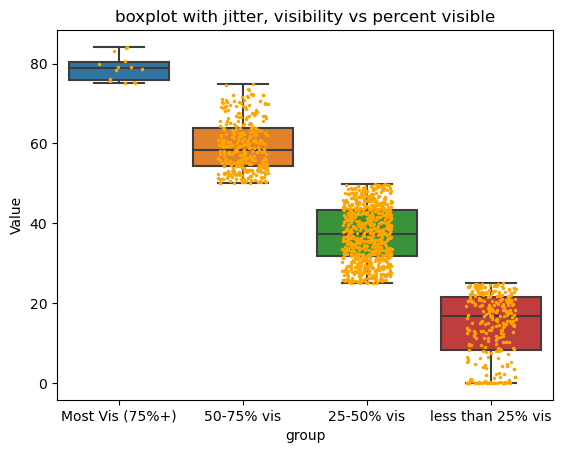

In [258]:
import seaborn as sns
import pandas as pd

# a = pd.DataFrame({'group': Over75PercValues, 'Most Vis (75%+)': range(len(Over75PercValues))})
# b = pd.DataFrame({'group': fiftyToSeventyFivePercValues, '50% - 75%': range(len(fiftyToSeventyFivePercValues))})



a = pd.DataFrame({'group': np.repeat('Most Vis (75%+)', (len(Over75PercValues))), 'Value': Over75PercValues})
b = pd.DataFrame({'group': np.repeat('50-75% vis', (len(fiftyToSeventyFivePercValues))), 'Value': fiftyToSeventyFivePercValues })
c =pd.DataFrame({'group': np.repeat('25-50% vis', (len(twentyfivetofiftyPercVal))), 'Value': twentyfivetofiftyPercVal })
d = pd.DataFrame({'group': np.repeat('less than 25% vis', (len(under25PercVal))), 'Value': under25PercVal })
df = pd.concat([a,b,c,d])

#sns.violinplot(x='group', y='Value', data=df)



ax = sns.boxplot(x = 'group', y = 'Value', data = df)

#add "stripplot"?
x = sns.stripplot(x='group', y = 'Value', color = 'orange', jitter = 0.2, size = 2.5, data = df)

plt.title("boxplot with jitter, visibility vs percent visible")



In [98]:
#shows whole df
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    print(df)

      group  Most Vis (75%+)  50% - 75%
0    79.157              0.0        NaN
1    79.118              1.0        NaN
2    84.007              2.0        NaN
3    75.189              3.0        NaN
4    78.365              4.0        NaN
5    83.222              5.0        NaN
6    80.595              6.0        NaN
7    84.176              7.0        NaN
8    75.657              8.0        NaN
9    75.292              9.0        NaN
10   78.667             10.0        NaN
11   79.901             11.0        NaN
12   76.159             12.0        NaN
13   75.104             13.0        NaN
0    57.783              NaN        0.0
1    51.175              NaN        1.0
2    55.649              NaN        2.0
3    51.018              NaN        3.0
4    54.562              NaN        4.0
5    58.902              NaN        5.0
6    61.200              NaN        6.0
7    54.811              NaN        7.0
8    69.070              NaN        8.0
9    52.558              NaN        9.0


In [159]:
"""
top 20 lists

"""

def top20(dict_a):
    """
    this function prints, in decreasing order, molecules with the highest visibility percentage in the column density predicted error ranges
    """
    top20list = []

    for i in dict_a:
        
        if dict_a[i].errorGauss5sigma() == None:
            continue
        elif dict_a[i].errorGauss5sigma() > 75: #over 75 just gets 14 molecules, can go down to 70 but make sure to have this in mind if looking at othe rmetrics
            if len(dict_a[i].name) != 0:
                top20list.append([dict_a[i].name, dict_a[i].errorGauss5sigma(), dict_a[i].id])
            else:
                #mlcIndex = 
                mlcIndex='molecule index ' + str(dict_a[i].id) + ' with formula ' + str(dict_a[i].formula)
                top20list.append([mlcIndex,dict_a[i].errorGauss5sigma()])

    return sorted(top20list, key=lambda x: x[1], reverse = True)[:20]

def top20_st(dict_a):
    """
    FOR STACKED
    this function prints, in decreasing order, molecules with the highest visibility percentage in the column density predicted error ranges
    """
    top20list_st = []

    for i in dict_a:
        
        if dict_a[i].errorGauss5sigma_st() == None:
            continue
        elif dict_a[i].errorGauss5sigma_st() > 70:
            if len(dict_a[i].name) != 0:
                top20list_st.append([dict_a[i].name,dict_a[i].errorGauss5sigma_st()])
            else:
                #mlcIndex = 
                mlcIndex='molecule index ' + str(dict_a[i].id) + ' with formula ' + str(dict_a[i].formula)
                top20list_st.append([mlcIndex,dict_a[i].errorGauss5sigma_st()])

    return sorted(top20list_st, key=lambda x: x[1], reverse = True)[:20]

## Implementing meta analysis

In [184]:
for i in tqdm(molecules2): 
    #count how many molecules don't have at least 3 lines over 5 sigma
    totalNoFive = noFiveSig(molecules2)
    
    #how many total molecules have at least 3 lines over 5 sigma
    haveOverFive = len((molecules2)) - totalNoFive

print(haveOverFive, 'have at least 3 lines over 5 sigma')
print('there are', uptotwentyfiveErrorRange(molecules2) , ' molecules with visible ranges up to 25%')
print('there are', twentyfivetofiftyErrorRange(molecules2) , ' molecules with visible ranges between 25% to 50%')
print('there are', fiftytoseventyfiveErrorRange(molecules2) , ' molecules with visible ranges 50% to 75%')
print('there are', overseventyfiveErrorRange(molecules2) , ' molecules with visible over 75%')
upto25(molecules2)
twentyfivetofifty(molecules2)
fiftyto75(molecules2)
over75(molecules2)




## code testing area

In [77]:
#next, i want to start evaluating the types of molecules
#will have to call the internal_smi column
import pandas as pd

columns = ['internal_smi']
df = pd.read_csv('/summary.csv', usecols=columns)
smilesstring = (df.iloc[:,0]).to_numpy() # converts pandas to numpy.array

smilesstring[0]
#maybe stick with something easy?
#maybe what perctanges ranges have N
#that'll get me starrted on heteroatoms at least

'C#CC#CC#CCC'

In [80]:
'C' in smilesstring[0]

True

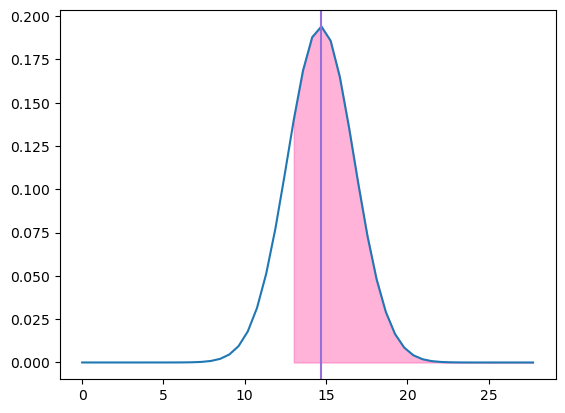

In [219]:
mu = molecules2[620].log_pred_cd
stanDev = molecules2[620].log_pred_err
x_axis = np.linspace(0,molecules2[620].log_pred_cd_high + 11)
minCD = np.log10(molecules2[620].five_sig_thresh)
plt.plot(x_axis, norm.pdf(x_axis, mu,stanDev))
#plt.grid()
#plt.grid(which='minor', alpha=0.2)
plt.axvline(x = mu, color = 'mediumpurple', label = 'ML-predicted column density')


#plt.axvline(x = minCD, color = 'orange', label = 'Minimum CD for 3 lines over 5 sigma')

#filling the curved area
x_vis = x_axis[(x_axis>=minCD) ]
plt.fill_between(x_vis, gaussian(x_vis, mu, stanDev), alpha = 0.5, color = 'hotpink')




#     delta = sig
#     bounds = np.array([mu - delta, mu + delta])
#     xf = x[(x>=bounds[0]) & (x<=bounds[1])]

In [176]:

def gaussianVisual(self): #(freq, mu, minCD):
    """

    """   
    #check if there were lines in the range
    if self.flags is not None and 'No Lines in Range' in self.flags:
        #print('No lines were in the range to simulate, so cannot plot anything.  Sorry.')
        return

    #check to make sure the five sigma analysis was run
    if self.five_sig_thresh is None:
#            print('No threshold has been set yet.  Cannot plot.  Sorry.')
        return

    mu = self.log_pred_cd
    stanDev = self.log_pred_err
    x_axis = np.linspace(self.log_pred_cd_low - 8,self.log_pred_cd_high + 8 )
    minCD = np.log10(self.five_sig_thresh)
    plt.plot(x_axis, norm.pdf(x_axis, mu,stanDev), color = 'deepskyblue', linewidth = 2.5)
    plt.axvline(x = mu, color = 'black', label = 'ML-predicted column density', linewidth = 2)
    plt.axhline(y=0, color = 'deepskyblue', linewidth = 2)

    #making plots pretty
    plt.xlabel("Log Column Densities")
    plt.yticks([])
    plt.xticks([])
    plt.tick_params(axis='y', which='both', right=False, left=False, labelleft=False)
    ax = plt.gca()#get current axes
    ax.set_frame_on(False);


    #filling the curved area
    #next two lines work, fill it with pretty pink
    x_vis = x_axis[(x_axis>=minCD) ]
    plt.fill_between(x_vis, gaussian(x_vis, mu, stanDev), alpha = 0.5, color = 'hotpink')







# cellb elow this is useful for pretty gradient figures for paper

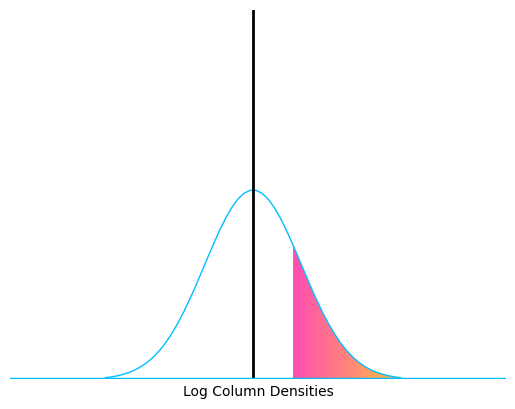

In [358]:
"""

this cell is good for a few molecules and for paper
i'm having a hard time making the gradient for a function
so real function code might just be basic bitch colors

"""

mu = molecules2[6].log_pred_cd
stanDev = molecules2[6].log_pred_err
x_axis = np.linspace(molecules2[6].log_pred_cd_low - 8,molecules2[6].log_pred_cd_high + 8 )
minCD = np.log10(molecules2[6].five_sig_thresh)
plt.plot(x_axis, norm.pdf(x_axis, mu,stanDev), color = 'deepskyblue', linewidth = 1)
#plt.grid()
#plt.grid(which='minor', alpha=0.2)
plt.axvline(x = mu, color = 'black', label = 'ML-predicted column density', linewidth = 2)
plt.axhline(y=0, color = 'deepskyblue', linewidth = 2.5)

#making plots pretty
plt.xlabel("Log Column Densities")

plt.yticks([])
plt.xticks([])
plt.tick_params(axis='y', which='both', right=False, left=False, labelleft=False)
ax = plt.gca()#get current axes
#ax.annotate('')
# ax.spines['top'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
ax.set_frame_on(False);
ax.annotate('test')




#filling the curved area
#next two lines work, fill it with pretty pink
# x_vis = x_axis[(x_axis>=minCD) ]
# plt.fill_between(x_vis, gaussian(x_vis, mu, stanDev), alpha = 0.5, color = 'hotpink')



#below is pretty but lol i am not so sure how to fix this
polygon = plt.fill_between(x_vis, gaussian(x_vis, mu, stanDev), alpha = 0.5, color = 'none')
verts = np.vstack([p.vertices for p in polygon.get_paths()])
gradient = plt.imshow(np.linspace(0, 1, 256).reshape(1, -1), cmap='gnuplot2', aspect='auto',
                       extent=[-10,30,0,0.2])
gradient.set_clip_path(polygon.get_paths()[0], transform=plt.gca().transData)


# polygon = plt.fill_between(x_vis, gaussian(x_vis, mu, stanDev), alpha = 0.5, color = 'none')
# verts = np.vstack([p.vertices for p in polygon.get_paths()])
# gradient = plt.imshow(np.linspace(0, 1, 256).reshape(1, -1), cmap='turbo', aspect='auto',
#                       extent=[verts[:, 0].min(), verts[:, 0].max(), verts[:, 1].min(), verts[:, 1].max()])
# gradient.set_clip_path(polygon.get_paths()[0], transform=plt.gca().transData)


#color maps i liked:
#PuRd
#gist_rainbow
#hsv
#prism
#gist_ncar
#gbuplot2

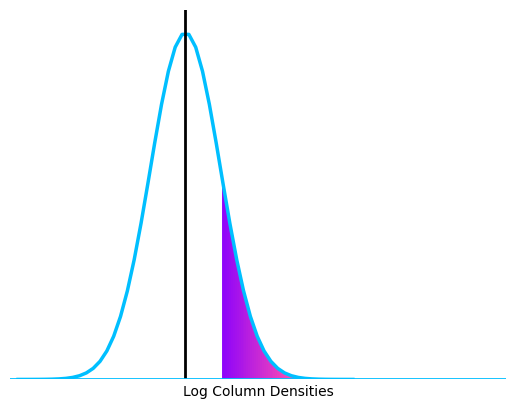

In [334]:
mu = molecules2[62].log_pred_cd
stanDev = molecules2[62].log_pred_err
x_axis = np.linspace(molecules2[62].log_pred_cd_low - 8,molecules2[62].log_pred_cd_high + 8 )
minCD = np.log10(molecules2[62].five_sig_thresh)
plt.plot(x_axis, norm.pdf(x_axis, mu,stanDev), color = 'deepskyblue', linewidth = 2.5)
#plt.grid()
#plt.grid(which='minor', alpha=0.2)
plt.axvline(x = mu, color = 'black', label = 'ML-predicted column density', linewidth = 2)
plt.axhline(y=0, color = 'deepskyblue', linewidth = 2)

#making plots pretty
plt.xlabel("Log Column Densities")
plt.yticks([])
plt.xticks([])
plt.tick_params(axis='y', which='both', right=False, left=False, labelleft=False)
ax = plt.gca()#get current axes
#ax.annotate('')
# ax.spines['top'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
ax.set_frame_on(False);




#filling the curved area
#next two lines work, fill it with pretty pink
# x_vis = x_axis[(x_axis>=minCD) ]
# plt.fill_between(x_vis, gaussian(x_vis, mu, stanDev), alpha = 0.5, color = 'hotpink')



#below is pretty but lol i am not so sure how to fix this
polygon = plt.fill_between(x_vis, gaussian(x_vis, mu, stanDev), alpha = 0.5, color = 'none')
verts = np.vstack([p.vertices for p in polygon.get_paths()])
gradient = plt.imshow(np.linspace(0, 1, 256).reshape(1, -1), cmap='gnuplot2', aspect='auto',
                       extent=[0,30,0,0.2])
gradient.set_clip_path(polygon.get_paths()[0], transform=plt.gca().transData)


# polygon = plt.fill_between(x_vis, gaussian(x_vis, mu, stanDev), alpha = 0.5, color = 'none')
# verts = np.vstack([p.vertices for p in polygon.get_paths()])
# gradient = plt.imshow(np.linspace(0, 1, 256).reshape(1, -1), cmap='turbo', aspect='auto',
#                       extent=[verts[:, 0].min(), verts[:, 0].max(), verts[:, 1].min(), verts[:, 1].max()])
# gradient.set_clip_path(polygon.get_paths()[0], transform=plt.gca().transData)


#color maps i liked:
#PuRd
#gist_rainbow
#hsv
#prism
#gist_ncar
#gbuplot2

# working on cell below figure as of aug 23

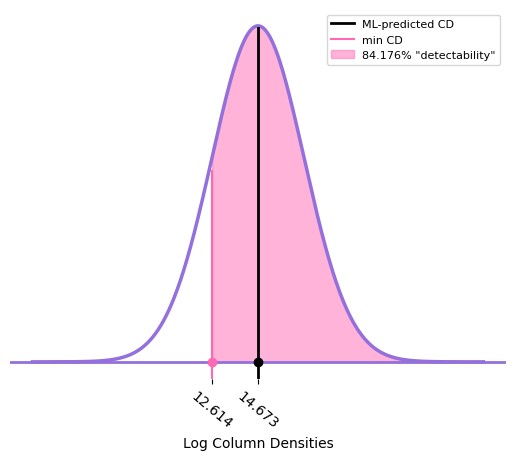

In [182]:
#this one, as of aug 24

mu = molecules2[620].log_pred_cd
stanDev = molecules2[620].log_pred_err
x_axis = np.linspace(molecules2[620].log_pred_cd_low - 8,molecules2[620].log_pred_cd_high + 8,1000 )
minCD = np.log10(molecules2[620].five_sig_thresh)
areaUnderCurve = round(molecules2[620].errorGauss5sigma(),3)
yvalueMu = np.interp(mu, x_axis,norm.pdf(x_axis, mu,stanDev))
minCDymax = np.interp(minCD, x_axis,norm.pdf(x_axis, mu,stanDev))

#actual plot data
plt.plot(x_axis, norm.pdf(x_axis, mu,stanDev), color = 'mediumpurple', linewidth = 2.5)
plt.axvline(x = mu, color = 'black', label = 'ML-predicted CD', linewidth = 2, ymax=.95)
plt.axhline(y=0, color = 'mediumpurple', linewidth = 2)
plt.axvline(x=minCD, color = 'hotpink', label='min CD', ymax=((minCDymax)/(yvalueMu))*.93)
mu_val = plt.plot(mu,0, marker = 'o', color = 'black') #ML-predicted CD val
minCD_val = plt.plot(minCD,0, marker='o', color = 'hotpink')



#filling the curved area
x_vis = x_axis[(x_axis>=minCD) ]
plt.fill_between(x_vis, norm.pdf(x_vis, mu, stanDev), alpha = 0.5, color = 'hotpink', label=(str(areaUnderCurve)+'% "detectability"'))
 



#making plots pretty
plt.xlabel("Log Column Densities")
plt.legend(loc = 'upper right', fontsize=8)

#tick management
plt.yticks([])
plt.xticks([mu, minCD], rotation = 320)
plt.tick_params(axis='y', which='both', right=False, left=False, labelleft=False)
ax = plt.gca()#get current axes
ax.set_frame_on(False);


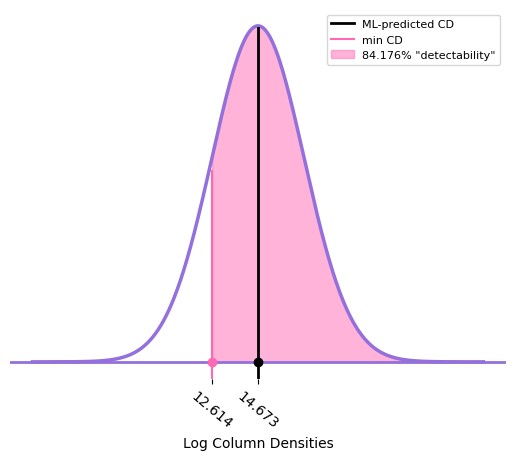

In [525]:
#this one, as of aug 24

mu = molecules2[620].log_pred_cd
stanDev = molecules2[620].log_pred_err
x_axis = np.linspace(molecules2[620].log_pred_cd_low - 8,molecules2[620].log_pred_cd_high + 8,1000 )
minCD = np.log10(molecules2[620].five_sig_thresh)
areaUnderCurve = round(molecules2[620].errorGauss5sigma(),3)
yvalueMu = np.interp(mu, x_axis,norm.pdf(x_axis, mu,stanDev))
minCDymax = np.interp(minCD, x_axis,norm.pdf(x_axis, mu,stanDev))

#actual plot data
plt.plot(x_axis, norm.pdf(x_axis, mu,stanDev), color = 'mediumpurple', linewidth = 2.5)
plt.axvline(x = mu, color = 'black', label = 'ML-predicted CD', linewidth = 2, ymax=.95)
plt.axhline(y=0, color = 'mediumpurple', linewidth = 2)
plt.axvline(x=minCD, color = 'hotpink', label='min CD', ymax=((minCDymax)/(yvalueMu))*.93)
mu_val = plt.plot(mu,0, marker = 'o', color = 'black') #ML-predicted CD val
minCD_val = plt.plot(minCD,0, marker='o', color = 'hotpink')



#filling the curved area
x_vis = x_axis[(x_axis>=minCD) ]
plt.fill_between(x_vis, gaussian(x_vis, mu, stanDev), alpha = 0.5, color = 'hotpink', label=(str(areaUnderCurve)+'% "detectability"'))
 



#making plots pretty
plt.xlabel("Log Column Densities")
plt.legend(loc = 'upper right', fontsize=8)

#tick management
plt.yticks([])
plt.xticks([mu, minCD], rotation = 320)
plt.tick_params(axis='y', which='both', right=False, left=False, labelleft=False)
ax = plt.gca()#get current axes
ax.set_frame_on(False);


In [486]:
yvalueMu

0.19409014950428327

In [409]:
(minCDymax)/(yvalueMu)

1.2450518857325121

In [410]:
minCDymax

0.1641858702578501

In [492]:
mu

14.67252061

In [377]:
np.interp(minCD, x_axis,norm.pdf(x_axis, mu,stanDev))

0.13187070526081185

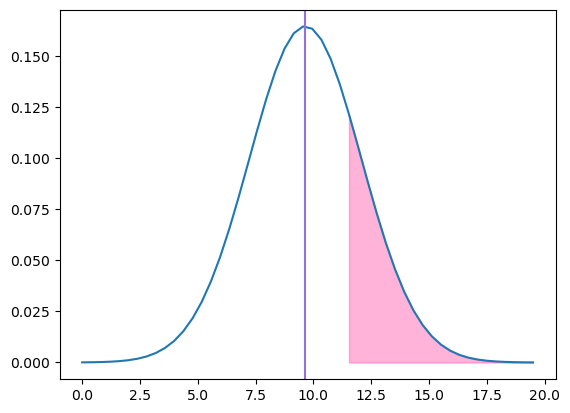

In [215]:
mu = molecules2[10].log_pred_cd
stanDev = molecules2[10].log_pred_err
x_axis = np.linspace(0,19.5)
minCD = np.log10(molecules2[10].five_sig_thresh)
#x_axis = np.linspace(molecules2[0].log_pred_cd_low, molecules2[0].log_pred_cd_high)
#plottingX =  np.linspace(molecules2[10].log_pred_cd_low**10, molecules2[10].log_pred_cd_high**10)
plt.plot(x_axis, norm.pdf(x_axis, mu,stanDev))
#plt.grid()
#plt.grid(which='minor', alpha=0.2)
plt.axvline(x = mu, color = 'mediumpurple', label = 'ML-predicted column density')


#plt.axvline(x = minCD, color = 'orange', label = 'Minimum CD for 3 lines over 5 sigma')

#filling the curved area
x_vis = x_axis[(x_axis>=minCD) ]
plt.fill_between(x_vis, gaussian(x_vis, mu, stanDev), alpha = 0.5, color = 'hotpink')




#     delta = sig
#     bounds = np.array([mu - delta, mu + delta])
#     xf = x[(x>=bounds[0]) & (x<=bounds[1])]


In [ ]:
    def five_sig_colorbar(self):
        """
        for old metric!
        function plots a colorbar showing how much of the column density error region has 3 lines over 3 sigma
        """
        #check if there were lines in the range
        if self.flags is not None and 'No Lines in Range' in self.flags:
            print('No lines were in the range to simulate, so cannot plot anything.  Sorry.')
            return
        
        #check to make sure the five sigma analysis was run
        if self.five_sig_thresh is None:
            print('No threshold has been set yet.  Cannot plot.  Sorry.')
            return
        
        
        fig, ax = plt.subplots(figsize=(5, 1))
        fig.subplots_adjust(bottom=0.5)

        cmap = matplotlib.cm.hot #viridis, cool, rainbow for other color options
        unsortedRegions = [self.log_pred_cd_low, np.log10(self.five_sig_thresh), self.log_pred_cd_high]
        CDregions=sorted(unsortedRegions)
        
        norm = matplotlib.colors.BoundaryNorm(CDregions, cmap.N,)

        cb=fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=ax,  orientation='horizontal', spacing='proportional',
             label="log Column Density")
        cb.ax.axvline(x=self.log_pred_cd,c='r')

        #cb.set_ticks(original_ticks+[self.log_pred_cd])
        ax.tick_params(labelsize=10)
        #cb.set_ticklabels(original_ticks+['predicted'])
        return 

## checking results region below

In [20]:
molecules[5].name

'7-methoxyhepta-1,3,5-triyne'

In [18]:
molecules[5].perc_vis5()

59.81756548558028

In [522]:
molecules2[5].five_sig_colorbar()

AttributeError: 'Result' object has no attribute 'five_sig_colorbar'

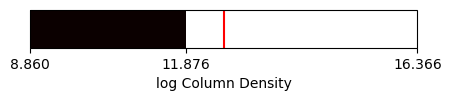

In [19]:
molecules[5].five_sig_colorbar()

In [22]:
molecules[0].five_sig_thresh #not a function

974295961600.6355

In [55]:
totalCDRange = molecules[0].log_pred_cd_high - molecules[0].log_pred_cd_low
visCD = molecules[0].log_pred_cd_high - np.log10(molecules[0].five_sig_thresh)
perc5 = (visCD/totalCDRange)*100
print(perc5)

26.68574312387556


In [31]:
totalCDRange = molecules[0].log_pred_cd_high - molecules[0].log_pred_cd_low
visCD = molecules[0].log_pred_cd_high - np.log10(molecules[0].five_sig_thresh)
perc5 = (visCD/totalCDRange)*100
print(perc5)

26.68574312387556


In [123]:
molecules2[0].plot_five_sig()

No threshold has been set yet.  Cannot plot.  Sorry.


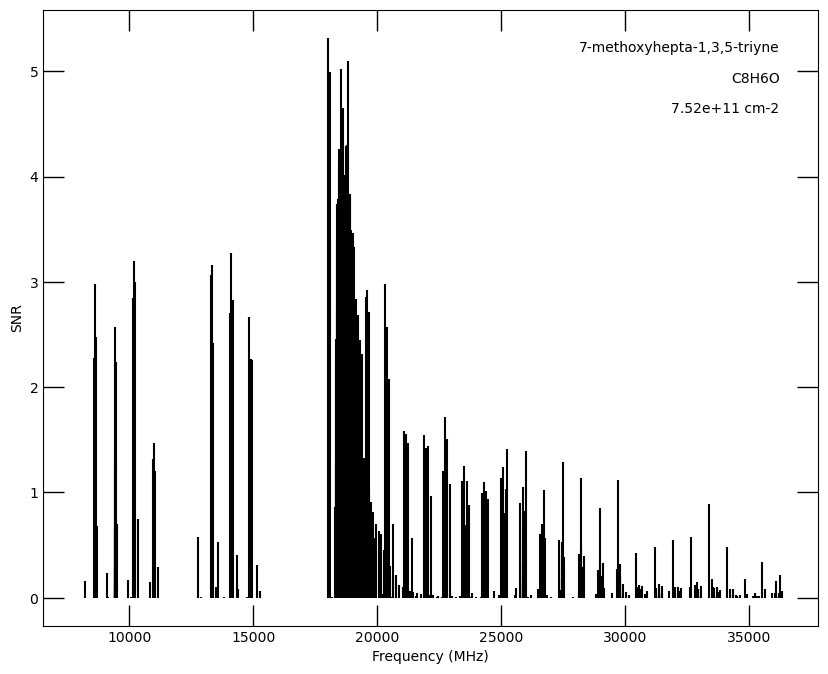

In [34]:
molecules[5].plot_five_sig()

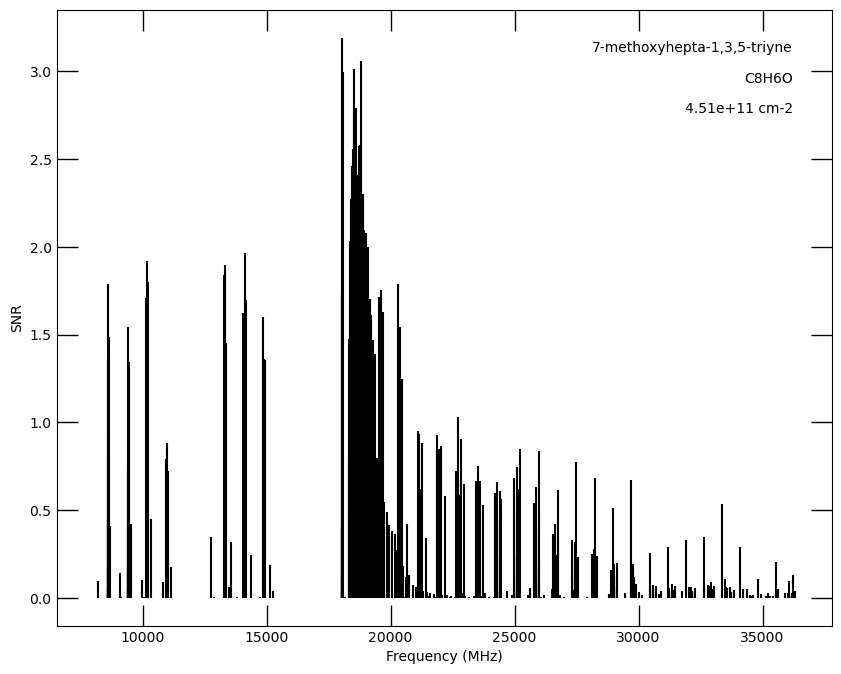

In [45]:
molecules[5].plot_three_sig()

In [46]:
molecules[5].three_sig_thresh

451273521611.6298

In [42]:
molecules[5].five_sig_thresh

752122536019.3829